In [4]:
pip install hugchat

In [5]:
import asyncio
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import time
from hugchat.hugchat import ChatBot
from hugchat.login import Login
import json
import sys
import re
import os

random.seed(11)

# Constants
GRID_SIZE = 15
NUM_BUILDINGS = 7
NUM_CIVILIANS = 8
NUM_TYPE1_FIRES = 5
NUM_TYPE2_FIRES = 3
MAX_STEPS = 50
SENSOR_RANGE = 2

# Cell types
EMPTY = 0
BUILDING = 1
CIVILIAN = 2
FIRE = 3
AGENT1 = 4
AGENT2 = 5
STATION = 6
LARGE_FIRE = 7

# Custom color mapping
COLORS = {
    EMPTY: "lightgray",
    BUILDING: "yellow",
    CIVILIAN: "blue",
    FIRE: "red",
    AGENT1: "green",
    AGENT2: "cyan",
    STATION: "purple",
    LARGE_FIRE: "orange"
}
DISCOVERED_COLORS = COLORS.copy()
DISCOVERED_COLORS[-1] = "black"

# Create custom colormaps
FULL_CMAP = ListedColormap([COLORS[i] for i in range(8)])
DISCOVERED_CMAP = ListedColormap([DISCOVERED_COLORS[i] for i in sorted(DISCOVERED_COLORS.keys())])

# Legend labels
COLOR_LEGEND = {
    "Empty (0)": COLORS[EMPTY],
    "Building (1)": COLORS[BUILDING],
    "Civilian (2)": COLORS[CIVILIAN],
    "Type 1 Fire (3)": COLORS[FIRE],
    "Agent 1 (4)": COLORS[AGENT1],
    "Agent 2 (5)": COLORS[AGENT2],
    "Station (6)": COLORS[STATION],
    "Type 2 Fire (7)": COLORS[LARGE_FIRE],
    "Unknown (-1)": DISCOVERED_COLORS[-1]
}

class Environment:
    def __init__(self):
        self.grid = np.zeros((GRID_SIZE, GRID_SIZE), dtype=int)
        self.civilians_rescued = 0
        self.type1_fires_extinguished = 0
        self.type2_fires_extinguished = 0
        self.score = 0
        self.steps = 0
        self.setup_environment()

    def setup_environment(self):
        self.grid[0, 0] = STATION
        self.grid[14, 14] = STATION
        for _ in range(NUM_BUILDINGS):
            self.place_random_entity(BUILDING)
        for _ in range(NUM_CIVILIANS):
            self.place_random_entity(CIVILIAN)
        for _ in range(NUM_TYPE1_FIRES):
            self.place_random_entity(FIRE)
        for _ in range(NUM_TYPE2_FIRES):
            self.place_random_entity(LARGE_FIRE)

    def place_random_entity(self, entity):
        while True:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if self.grid[x, y] == EMPTY:
                self.grid[x, y] = entity
                break

    def spread_fire(self):
        fire_positions = list(zip(*np.where((self.grid == FIRE) | (self.grid == LARGE_FIRE))))
        if not fire_positions:
            return
        for x, y in fire_positions[:]:
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            random.shuffle(directions)
            for dx, dy in directions:
                new_x, new_y = x + dx, y + dy
                if (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and
                    self.grid[new_x, new_y] not in [FIRE, LARGE_FIRE, BUILDING, STATION, AGENT1, AGENT2]):
                    if self.grid[new_x, new_y] == CIVILIAN:
                        self.score -= 100
                        print(f"Civilian died in fire! Score: {self.score}")
                    self.grid[new_x, new_y] = FIRE  # All fires spread as Type 1
                    break

    def get_grid(self):
        return self.grid

    def update_cell(self, x, y, value):
        self.grid[x, y] = value

    def increment_step(self):
        self.steps += 1

    def is_game_over(self):
        return (self.steps >= MAX_STEPS or
                (self.type1_fires_extinguished == NUM_TYPE1_FIRES and
                 self.type2_fires_extinguished == NUM_TYPE2_FIRES and
                 self.civilians_rescued == NUM_CIVILIANS))

    def apply_action(self, x, y, action, last_cell_content, agent_id, other_agent_pos):
        """
        Apply the specified action at position (x, y) for the given agent.
        Returns True if the action was successful, False otherwise.
        """
        if action == "extinguish fire" and last_cell_content == FIRE:
            self.update_cell(x, y, EMPTY)
            self.type1_fires_extinguished += 1
            self.score += 10
            print(f"Agent {agent_id} extinguished Type 1 fire! Score: {self.score}")
            return True
        elif action == "extinguish fire" and last_cell_content == LARGE_FIRE:
            # Check if both agents are on the same cell and both attempt to extinguish
            if other_agent_pos == (x, y):
                self.update_cell(x, y, EMPTY)
                self.type2_fires_extinguished += 1
                self.score += 25
                print(f"Agents cooperatively extinguished Type 2 fire! Score: {self.score}")
                return True
            return False
        elif action == "rescue civilian" and last_cell_content == CIVILIAN:
            self.update_cell(x, y, EMPTY)
            return True
        elif action == "deliver civilian" and last_cell_content == STATION:
            self.civilians_rescued += 1
            self.score += 50
            print(f"Agent {agent_id} delivered civilian! Score: {self.score}")
            return True
        return False

class LLMAgent:
    def __init__(self, environment, email, password, agent_id, shared_map):
        self.env = environment
        self.agent_id = agent_id
        self.agent_type = AGENT1 if agent_id == 1 else AGENT2
        self.pos = None
        self.shared_map = shared_map
        self.discovered_map = np.full((GRID_SIZE, GRID_SIZE), -1)
        self.carrying_civilian = False
        self.known_fires = []  # Type 1 fires
        self.known_large_fires = []  # Type 2 fires
        self.known_civilians = []
        self.known_buildings = []
        self.stations = [(0, 0), (14, 14)]
        self.llm_responses = []
        self.chatbot = self.initialize_chatbot(email, password)
        self.last_cell_content = EMPTY
        self.place_agent()
        self.update_discovered_map()

    def initialize_chatbot(self, email, password):
        sign = Login(email, password)
        cookies = sign.login()
        chatbot = ChatBot(cookies=cookies.get_dict())
        return chatbot

    def place_agent(self):
        while True:
            x, y = random.randint(0, GRID_SIZE-1), random.randint(0, GRID_SIZE-1)
            if self.env.get_grid()[x, y] == EMPTY:
                self.env.update_cell(x, y, self.agent_type)
                self.pos = [x, y]
                self.last_cell_content = EMPTY
                break
        self.discovered_map[0, 0] = STATION
        self.discovered_map[14, 14] = STATION
        self.shared_map[0, 0] = STATION
        self.shared_map[14, 14] = STATION

    def update_discovered_map(self):
        x, y = self.pos
        for i in range(max(0, x - SENSOR_RANGE), min(GRID_SIZE, x + SENSOR_RANGE + 1)):
            for j in range(max(0, y - SENSOR_RANGE), min(GRID_SIZE, y + SENSOR_RANGE + 1)):
                cell = self.env.get_grid()[i, j]
                self.discovered_map[i, j] = cell
                self.shared_map[i, j] = cell
                pos = (i, j)
                if cell == FIRE and pos not in self.known_fires:
                    self.known_fires.append(pos)
                elif cell == LARGE_FIRE and pos not in self.known_large_fires:
                    self.known_large_fires.append(pos)
                elif cell == CIVILIAN and pos not in self.known_civilians:
                    self.known_civilians.append(pos)
                elif cell == BUILDING and pos not in self.known_buildings:
                    self.known_buildings.append(pos)
                if cell != FIRE and pos in self.known_fires:
                    self.known_fires.remove(pos)
                if cell != LARGE_FIRE and pos in self.known_large_fires:
                    self.known_large_fires.remove(pos)
                if cell != CIVILIAN and pos in self.known_civilians:
                    self.known_civilians.remove(pos)

    def get_perception_view(self):
        x, y = self.pos
        view = np.full((5, 5), -1, dtype=int)
        for i in range(-SENSOR_RANGE, SENSOR_RANGE + 1):
            for j in range(-SENSOR_RANGE, SENSOR_RANGE + 1):
                grid_x, grid_y = x + i, y + j
                view_i, view_j = i + SENSOR_RANGE, j + SENSOR_RANGE
                if 0 <= grid_x < GRID_SIZE and 0 <= grid_y < GRID_SIZE:
                    view[view_i, view_j] = self.shared_map[grid_x, grid_y]
        return view

    def get_nearest_station(self):
        x, y = self.pos
        distances = [abs(x - sx) + abs(y - sy) for sx, sy in self.stations]
        min_distance = min(distances)
        nearest_station = self.stations[distances.index(min_distance)]
        return nearest_station, min_distance

    def generate_prompt(self, other_agent_pos, other_agent_carrying):
        perception_view = self.get_perception_view()
        nearest_station, distance = self.get_nearest_station()
        shared_map_str = np.array2string(self.shared_map, separator=', ')
        prompt = f"""
[AGENT STATUS]
Agent ID: {self.agent_id}
Grid size: ({GRID_SIZE}, {GRID_SIZE})
Agent Position: ({self.pos[0]}, {self.pos[1]})
Other Agent Position: {other_agent_pos}
Shared Map ({GRID_SIZE}x{GRID_SIZE}, -1=unknown, 0=empty, 1=building, 2=civilian, 3=Type1 fire, 4=agent1, 5=agent2, 6=station, 7=type2 fire):
{shared_map_str}
Carrying Civilian: {'Yes' if self.carrying_civilian else 'No'}
Other Agent Carrying Civilian: {'Yes' if other_agent_carrying else 'No'}
Last Cell Content: {self.last_cell_content} (0=Empty, 1=Building, 2=Civilian, 3=Type1 Fire, 6=Station, 7=type2 fire)
Nearest Station: {nearest_station} (Distance: {distance})
Score: {self.env.score}
Steps Remaining: {MAX_STEPS - self.env.steps}

[PRIORITY]
0. Avoid going to buildings(1) and out-of-bounds moves (grid size: {GRID_SIZE}x{GRID_SIZE}).
1. Deliver a civilian if Carrying Civilian is Yes and agent position is on a Station.
2. Rescue a civilian if on their position and Carrying Civilian is No.
3. Extinguish a Type 1 fire if on its position.
4. Move toward the nearest known civilian
5. Move toward the nearest known fire Type 1
6. Move toward the nearest known fire Type 2
7. Explore unknown areas (-1 in shared map) to find civilians or fires if no known targets exist.

[ACTION]
Choose the single best action considering the shared map, other agent's position, and priorities. Valid actions:
- "deliver civilian": If last cell content is 6 (a station) and Carrying Civilian is Yes.
- "rescue civilian": If last cell content is 2 (a civilian) and Carrying Civilian is No.
- "extinguish fire": If last cell content is 3 (a Type 1 fire) or If last cell content is 7 (Type 2 fire), requires other agent on same cell.
- "move up": Move to ({self.pos[0]-1}, {self.pos[1]}) if the positon ({self.pos[0]-1}, {self.pos[1]}) not a building (1) or out of bounds.
- "move right": Move to ({self.pos[0]}, {self.pos[1]+1}) if the positon ({self.pos[0]}, {self.pos[1]+1}) not a building (1) or out of bounds.
- "move down": Move to ({self.pos[0]+1}, {self.pos[1]}) if the positon ({self.pos[0]+1}, {self.pos[1]}) not a building (1) or out of bounds.
- "move left": Move to ({self.pos[0]}, {self.pos[1]-1}) if the positon ({self.pos[0]}, {self.pos[1]-1}) not a building (1) or out of bounds.

Respond with the chosen action in JSON format:
'''
{{
  "action": "move up|move down|move left|move right|extinguish fire|rescue civilian|deliver civilian",
  "reasoning": "Explain why this action is the best choice based on the current state, shared map, other agent's position, and priorities."
}}
'''
"""
        return prompt

    def validate_action(self, action, other_agent_pos):
        x, y = self.pos
        if action == "extinguish fire":
            return (self.last_cell_content == FIRE or
                    (self.last_cell_content == LARGE_FIRE and other_agent_pos == (x, y)))
        elif action == "rescue civilian":
            return self.last_cell_content == CIVILIAN and not self.carrying_civilian
        elif action == "deliver civilian":
            return self.last_cell_content == STATION and self.carrying_civilian
        elif action in ["move up", "move down", "move left", "move right"]:
            new_x, new_y = x, y
            if action == "move up":
                new_x -= 1
            elif action == "move down":
                new_x += 1
            elif action == "move left":
                new_y -= 1
            elif action == "move right":
                new_y += 1
            return (0 <= new_x < GRID_SIZE and 0 <= new_y < GRID_SIZE and
                    (self.shared_map[new_x, new_y] == -1 or
                     self.shared_map[new_x, new_y] not in [BUILDING]))
        return False

    def get_fallback_action(self, other_agent_pos):
        valid_actions = []
        for action in ["move up", "move down", "move left", "move right", "extinguish fire", "rescue civilian", "deliver civilian"]:
            if self.validate_action(action, other_agent_pos):
                valid_actions.append(action)
        return random.choice(valid_actions) if valid_actions else None

    async def move(self, other_agent_pos, other_agent_carrying):
        self.update_discovered_map()
        prompt = self.generate_prompt(other_agent_pos, other_agent_carrying)
        response_entry = {"step": self.env.steps, "agent_id": self.agent_id, "prompt": prompt, "action": None, "reasoning": None, "fallback": False}
        try:
            response = await asyncio.wait_for(
                asyncio.to_thread(self.chatbot.chat, prompt),
                timeout=10
            )
            response_text = response.text if hasattr(response, 'text') else str(response)

            if not response_text.strip():
                raise ValueError("Empty response from LLM")

            json_match = re.search(r'```json\n([\s\S]*?)\n```', response_text)
            if json_match:
                json_str = json_match.group(1)
            else:
                json_start = response_text.find('{')
                json_end = response_text.rfind('}') + 1
                if json_start != -1 and json_end != 0:
                    json_str = response_text[json_start:json_end]
                else:
                    raise ValueError("No valid JSON found in response")

            llm_output = json.loads(json_str)
            action = llm_output.get("action", "")
            reasoning = llm_output.get("reasoning", "No reasoning provided.")
            print(f"Step {self.env.steps} - Agent {self.agent_id}")
            print(f"LLM Action: {action}")
            print(f"Reasoning: {reasoning}")

            response_entry["action"] = action
            response_entry["reasoning"] = reasoning

            if self.validate_action(action, other_agent_pos):
                self.execute_action(action, other_agent_pos)
            else:
                print(f"Invalid action: {action}. Choosing fallback action.")
                fallback = self.get_fallback_action(other_agent_pos)
                if fallback:
                    print(f"Fallback Action: {fallback}")
                    response_entry["action"] = fallback
                    response_entry["reasoning"] = "Fallback action chosen due to invalid LLM action."
                    response_entry["fallback"] = True
                    self.execute_action(fallback, other_agent_pos)
                else:
                    print("No valid actions available. Skipping move.")
                    response_entry["action"] = "none"
                    response_entry["reasoning"] = "No valid actions available."
        except asyncio.TimeoutError:
            print("Timeout waiting for LLM response. Choosing fallback action.")
            fallback = self.get_fallback_action(other_agent_pos)
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to LLM timeout."
                response_entry["fallback"] = True
                self.execute_action(fallback, other_agent_pos)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to timeout."
        except json.JSONDecodeError as e:
            print(f"JSON parsing error: {e}. Extracted JSON: {json_str}")
            print("Choosing fallback action.")
            fallback = self.get_fallback_action(other_agent_pos)
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to JSON parsing error."
                response_entry["fallback"] = True
                self.execute_action(fallback, other_agent_pos)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to JSON error."
        except ValueError as e:
            print(f"Error processing response: {e}. Raw response: {response_text}")
            print("Choosing fallback action.")
            fallback = self.get_fallback_action(other_agent_pos)
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to response processing error."
                response_entry["fallback"] = True
                self.execute_action(fallback, other_agent_pos)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to response error."
        except Exception as e:
            print(f"Unexpected error: {e}. Raw response: {response_text}")
            print("Choosing fallback action.")
            fallback = self.get_fallback_action(other_agent_pos)
            if fallback:
                print(f"Fallback Action: {fallback}")
                response_entry["action"] = fallback
                response_entry["reasoning"] = "Fallback action chosen due to unexpected error."
                response_entry["fallback"] = True
                self.execute_action(fallback, other_agent_pos)
            else:
                print("No valid actions available. Skipping move.")
                response_entry["action"] = "none"
                response_entry["reasoning"] = "No valid actions available due to unexpected error."
        self.llm_responses.append(response_entry)

    def execute_action(self, action, other_agent_pos):
        x, y = self.pos
        if action == "extinguish fire":
            if self.last_cell_content in [FIRE, LARGE_FIRE]:
                success = self.env.apply_action(x, y, action, self.last_cell_content, self.agent_id, other_agent_pos)
                if success:
                    self.shared_map[x, y] = EMPTY
                    self.discovered_map[x, y] = EMPTY
                    if self.last_cell_content == FIRE and (x, y) in self.known_fires:
                        self.known_fires.remove((x, y))
                    elif self.last_cell_content == LARGE_FIRE and (x, y) in self.known_large_fires:
                        self.known_large_fires.remove((x, y))
                    self.last_cell_content = EMPTY
                    self.env.update_cell(x, y, self.agent_type)
                    self.discovered_map[x, y] = self.agent_type
                    self.shared_map[x, y] = self.agent_type
        elif action == "rescue civilian":
            if self.last_cell_content == CIVILIAN:
                success = self.env.apply_action(x, y, action, self.last_cell_content, self.agent_id, other_agent_pos)
                if success:
                    self.carrying_civilian = True
                    self.shared_map[x, y] = EMPTY
                    self.discovered_map[x, y] = EMPTY
                    if (x, y) in self.known_civilians:
                        self.known_civilians.remove((x, y))
                    self.last_cell_content = EMPTY
                    self.env.update_cell(x, y, self.agent_type)
                    self.discovered_map[x, y] = self.agent_type
                    self.shared_map[x, y] = self.agent_type
                    print(f"Agent {self.agent_id} picked up civilian!")
        elif action == "deliver civilian":
            if self.last_cell_content == STATION:
                success = self.env.apply_action(x, y, action, self.last_cell_content, self.agent_id, other_agent_pos)
                if success:
                    self.carrying_civilian = False
                    self.env.update_cell(x, y, STATION)
                    self.discovered_map[x, y] = STATION
                    self.shared_map[x, y] = STATION
        else:
            new_x, new_y = x, y
            if action == "move up":
                new_x -= 1
            elif action == "move down":
                new_x += 1
            elif action == "move left":
                new_y -= 1
            elif action == "move right":
                new_y += 1
            self.last_cell_content = self.env.get_grid()[new_x, new_y]
            self.env.update_cell(x, y, EMPTY)
            self.shared_map[x, y] = EMPTY
            self.pos = [new_x, new_y]
            self.env.update_cell(new_x, new_y, self.agent_type)
            self.update_discovered_map()

def display_maps(env, agent1, agent2, step, performance_metrics):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.imshow(env.get_grid(), cmap=FULL_CMAP, interpolation='nearest', vmin=0, vmax=7)
    ax1.set_title(f"Full City Map (Step {step})")
    ax1.axis('off')

    ax2.imshow(agent1.shared_map, cmap=DISCOVERED_CMAP, interpolation='nearest', vmin=-1, vmax=7)
    ax2.set_title("Agents' Shared Discovered Map")
    ax2.axis('off')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=label) for label, color in COLOR_LEGEND.items()]
    fig.legend(handles=legend_elements, loc='upper center', ncol=4, bbox_to_anchor=(0.5, -0.05), title="Color Key")

    plt.tight_layout()

    # Save performance metrics for analysis
    exploration_coverage = 1 - np.count_nonzero(agent1.shared_map == -1) / (GRID_SIZE * GRID_SIZE)
    performance_metrics.append({
        "step": step,
        "score": env.score,
        "civilians_rescued": env.civilians_rescued,
        "type1_fires_extinguished": env.type1_fires_extinguished,
        "type2_fires_extinguished": env.type2_fires_extinguished,
        "exploration_coverage": exploration_coverage
    })

    if sys.platform != "emscripten":
        try:
            plt.savefig(f'map_step_{step}.png', bbox_inches='tight')
        except Exception as e:
            print(f"Could not save plot for step {step}: {e}")

    plt.show()

async def run_multi_agent_simulation():
    EMAIL = ""
    PASSWORD = ""

    env = Environment()
    shared_map = np.full((GRID_SIZE, GRID_SIZE), -1, dtype=int)
    shared_map[0, 0] = STATION
    shared_map[14, 14] = STATION
    agent1 = LLMAgent(env, EMAIL, PASSWORD, agent_id=1, shared_map=shared_map)
    agent2 = LLMAgent(env, EMAIL, PASSWORD, agent_id=2, shared_map=shared_map)
    performance_metrics = []
    display_maps(env, agent1, agent2, env.steps, performance_metrics)
    while not env.is_game_over():
        # Both agents move in the same step
        await asyncio.gather(
            agent1.move(agent2.pos, agent2.carrying_civilian),
            agent2.move(agent1.pos, agent1.carrying_civilian)
        )
        env.increment_step()

        if env.steps % 5 == 0:
            env.spread_fire()

        display_maps(env, agent1, agent2, env.steps, performance_metrics)
        await asyncio.sleep(0.1)

        if (env.type1_fires_extinguished == NUM_TYPE1_FIRES and
            env.type2_fires_extinguished == NUM_TYPE2_FIRES and
            env.civilians_rescued == NUM_CIVILIANS):
            print(f"Success! All fires extinguished and civilians rescued in {env.steps} steps.")
            break

    if env.steps >= MAX_STEPS:
        print(f"Game Over! Final Score: {env.score}")
        print(f"Type 1 Fires extinguished: {env.type1_fires_extinguished}/{NUM_TYPE1_FIRES}")
        print(f"Type 2 Fires extinguished: {env.type2_fires_extinguished}/{NUM_TYPE2_FIRES}")
        print(f"Civilians rescued: {env.civilians_rescued}/{NUM_CIVILIANS}")

    print("\nLLM Responses for All Steps:")
    for agent, responses in [(1, agent1.llm_responses), (2, agent2.llm_responses)]:
        for response in responses:
            print(f"\nStep {response['step']} - Agent {response['agent_id']}:")
            print(f"Prompt:\n{response['prompt']}")
            print(f"Action: {response['action']}")
            print(f"Reasoning: {response['reasoning']}")
            if response['fallback']:
                print("Note: This was a fallback action.")

    # Performance Report
    print("\nPerformance Report:")
    print("Multi-Agent System:")
    print(f"Final Score: {env.score}")
    print(f"Civilians Rescued: {env.civilians_rescued}/{NUM_CIVILIANS}")
    print(f"Type 1 Fires Extinguished: {env.type1_fires_extinguished}/{NUM_TYPE1_FIRES}")
    print(f"Type 2 Fires Extinguished: {env.type2_fires_extinguished}/{NUM_TYPE2_FIRES}")
    final_coverage = performance_metrics[-1]['exploration_coverage'] if performance_metrics else 0
    print(f"Exploration Coverage: {final_coverage:.2%}")
    valid_actions = sum(1 for r in agent1.llm_responses + agent2.llm_responses if not r['fallback'])
    total_actions = len(agent1.llm_responses) + len(agent2.llm_responses)
    print(f"Valid Action Ratio: {valid_actions}/{total_actions} ({valid_actions/total_actions:.2%})")

    # Placeholder for single-agent comparison (HW2 results must be provided or simulated)
    print("\nSingle-Agent System (HW2) Comparison:")
    print("Note: Single-agent results not provided. Assuming baseline from HW2 code.")
    # Example placeholder values (replace with actual HW2 run if available)
    single_agent_score = 100  # Example
    single_agent_civilians = 5
    single_agent_fires = 3
    single_agent_coverage = 0.6
    print(f"Single-Agent Score: {single_agent_score}")
    print(f"Single-Agent Civilians Rescued: {single_agent_civilians}/{NUM_CIVILIANS}")
    print(f"Single-Agent Fires Extinguished: {single_agent_fires}/{NUM_TYPE1_FIRES}")
    print(f"Single-Agent Exploration Coverage: {single_agent_coverage:.2%}")

    improvement = env.score - single_agent_score
    print(f"\nPerformance Improvement: {improvement} points")

if __name__ == "__main__":
    if sys.platform == "emscripten" or "ipykernel" in sys.modules:
        loop = asyncio.get_event_loop()
        if loop.is_running():
            pass
        else:
            loop.run_until_complete(run_multi_agent_simulation())
    else:
        asyncio.run(run_multi_agent_simulation())

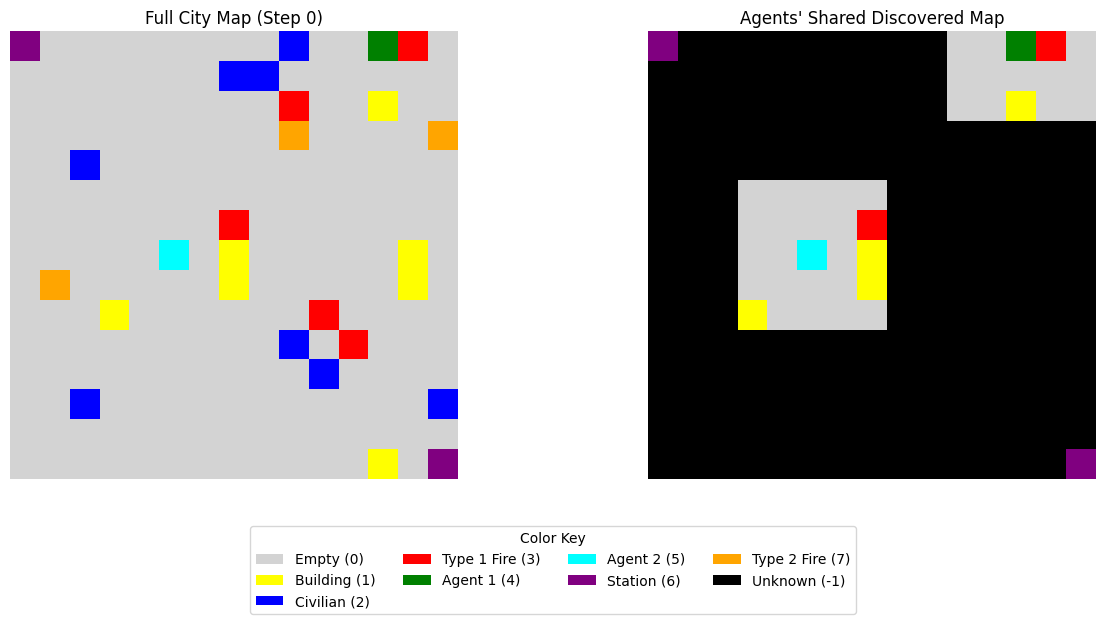

Step 0 - Agent 1
LLM Action: move right
Reasoning: The agent should move right because there is a known Type 1 fire at position (0, 13), which is directly to the right of the agent's current position (0, 12). This action follows priority 5, moving toward the nearest known fire Type 1, and is the most direct and immediate goal based on the shared map.
Step 0 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the nearest known Type 1 fire at position (7, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.


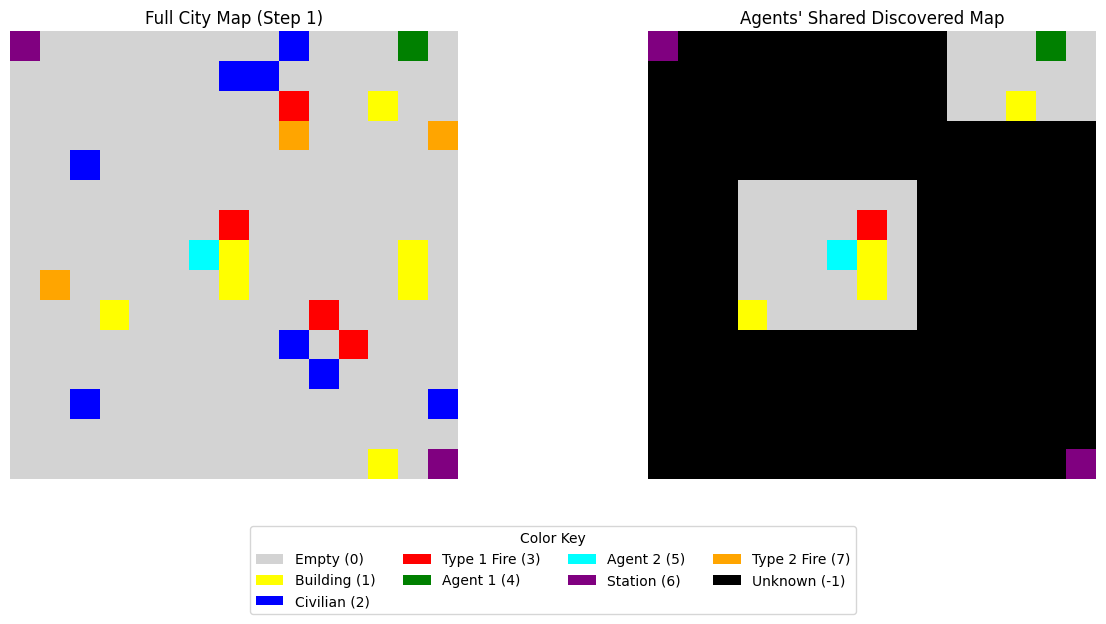

Step 1 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: 10
Step 1 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the nearest known Type 1 fire at position (7, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move down


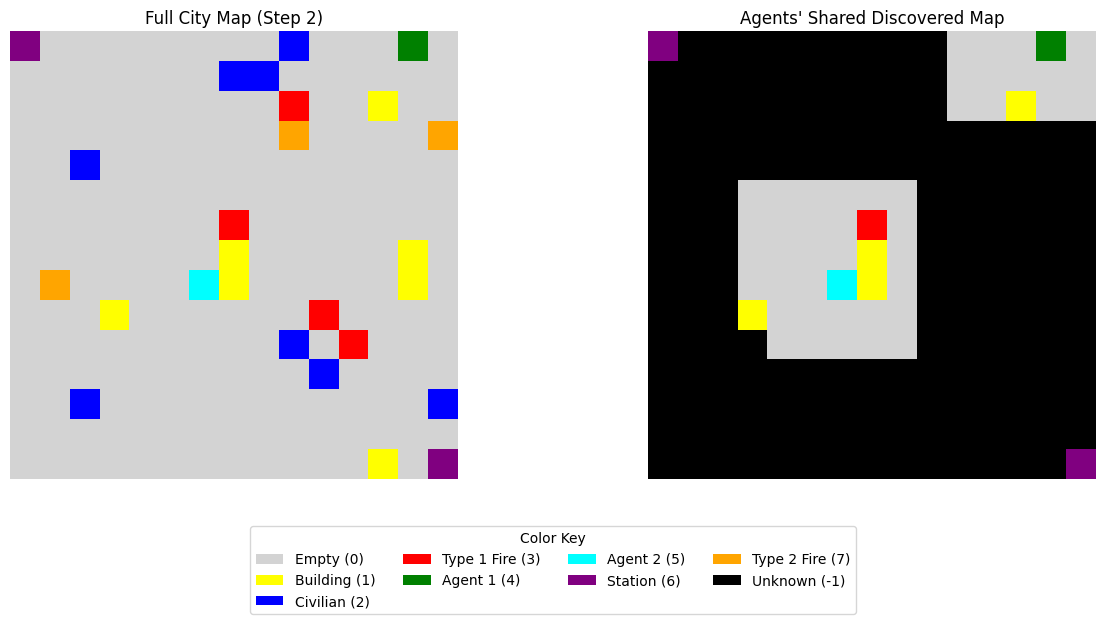

Step 2 - Agent 1
LLM Action: move down
Reasoning: The agent has just extinguished a Type 1 fire and is now in a position to move towards other potential targets. Moving down to (1, 13) is a safe move that avoids buildings and out-of-bounds areas, and brings the agent closer to the rest of the grid where other fires or civilians might be located.
Step 2 - Agent 2
LLM Action: move up
Reasoning: The agent is moving up to position (7, 6) to potentially move closer to the Type 1 fire at (7, 7) and to explore the area for civilians, following priorities 5 and 7. This action is chosen because it moves the agent towards a known issue (the fire) and into a position from which further actions can be more effectively decided.


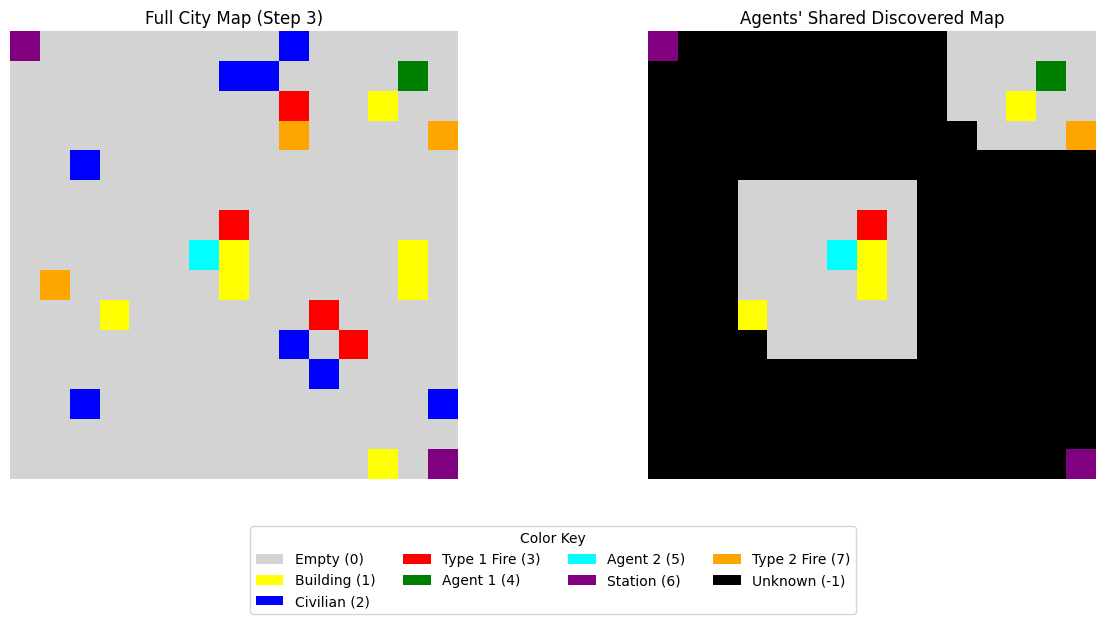

Step 3 - Agent 1
LLM Action: move right
Reasoning: The agent should move right because there is a known Type 2 fire at a nearby position, and moving right brings the agent closer to it. This action follows priority 6, moving toward the nearest known fire Type 2, and is the most direct and immediate goal based on the shared map.
Step 3 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the nearest known Type 1 fire at position (7, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


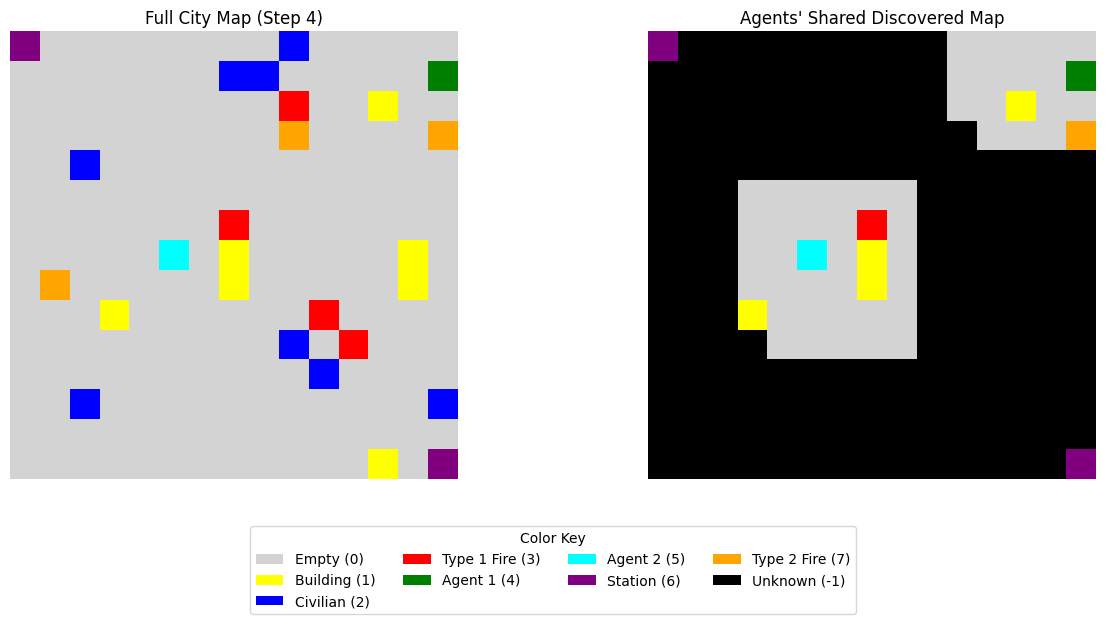

Step 4 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because there is a known Type 2 fire nearby, and moving down brings the agent closer to it. This action follows priority 6, moving toward the nearest known fire Type 2, and is the most direct and immediate goal based on the shared map.
Step 4 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the area where the Type 1 fire is located to potentially extinguish it or find other targets, following priority 5. This action is chosen because it moves the agent closer to a known issue (the fire) and is in line with the agent's capabilities and priorities.


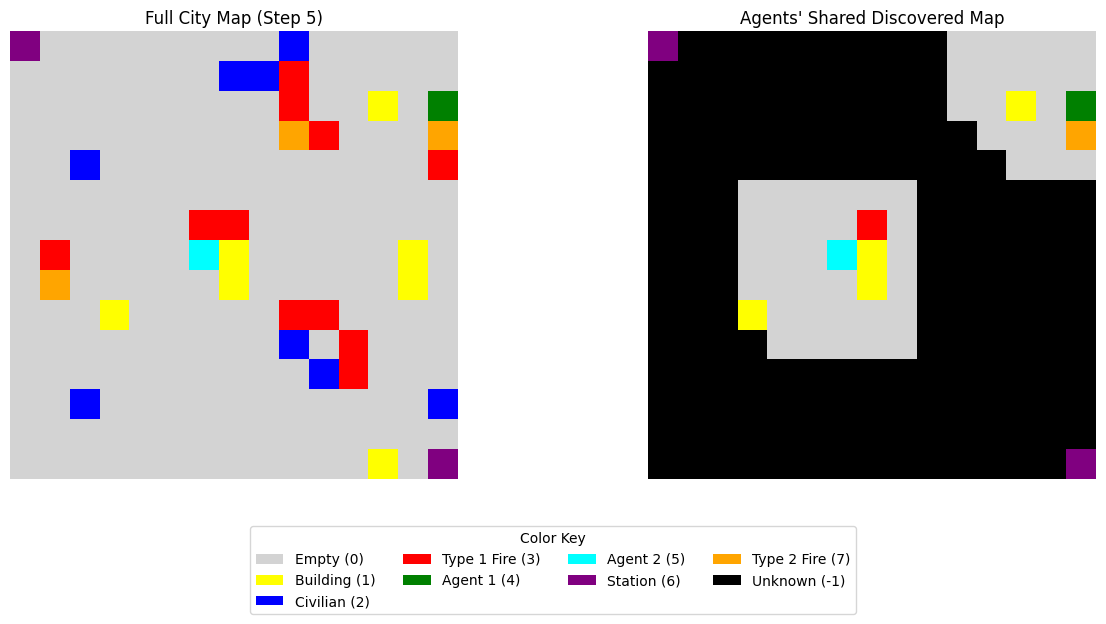

Step 5 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a known civilian nearby, and moving left brings the agent closer to it. This action follows priority 4, moving toward the nearest known civilian, and is the most direct and immediate goal based on the shared map.
Step 5 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the Type 1 fire at position (7, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move down


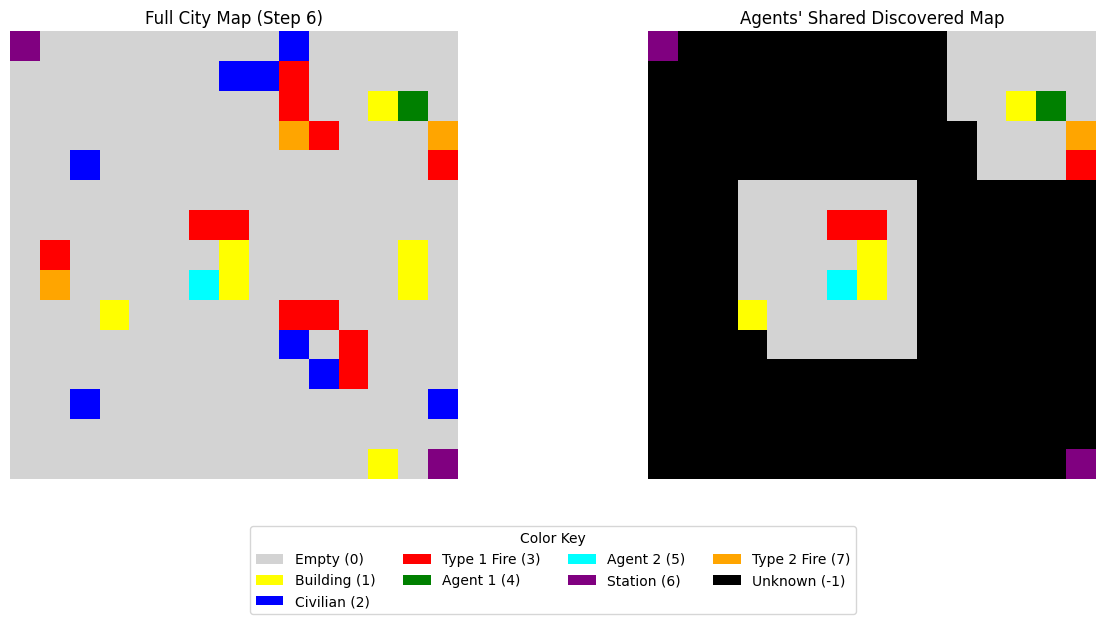

Step 6 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 6 - Agent 2
LLM Action: move up
Reasoning: The agent is moving up to position (7, 6) to potentially move closer to the Type 1 fires and to explore the area for other targets, following priorities 5 and 7. This action is chosen because it moves the agent towards a known area of interest and allows for further assessment of the situation.


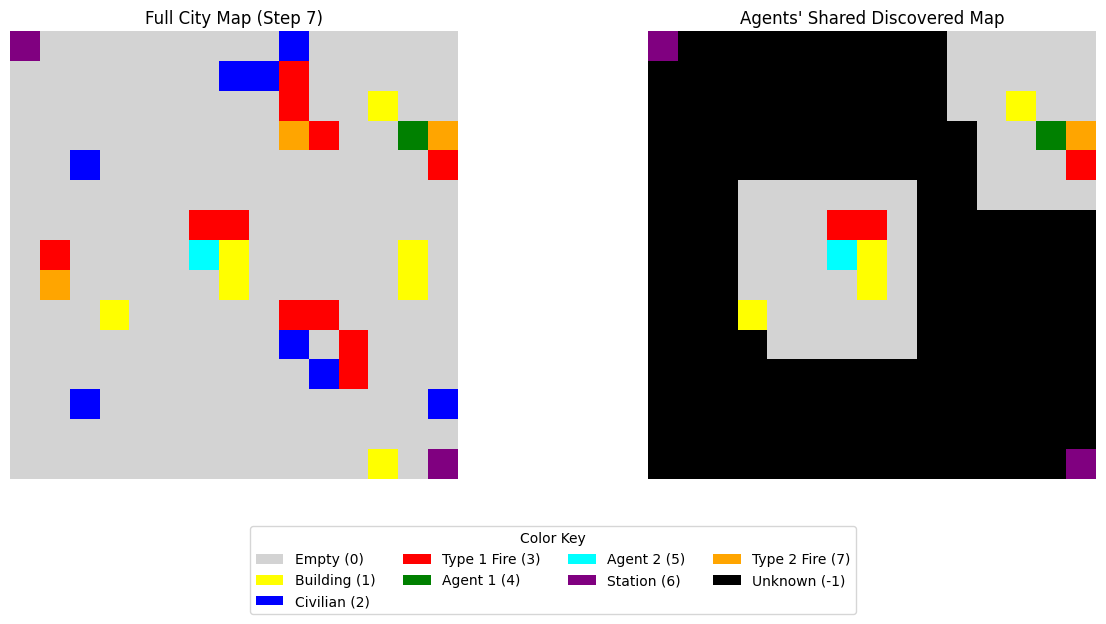

Step 7 - Agent 1
LLM Action: move up
Reasoning: The agent should move up because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 7 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the Type 1 fire at position (7, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move up


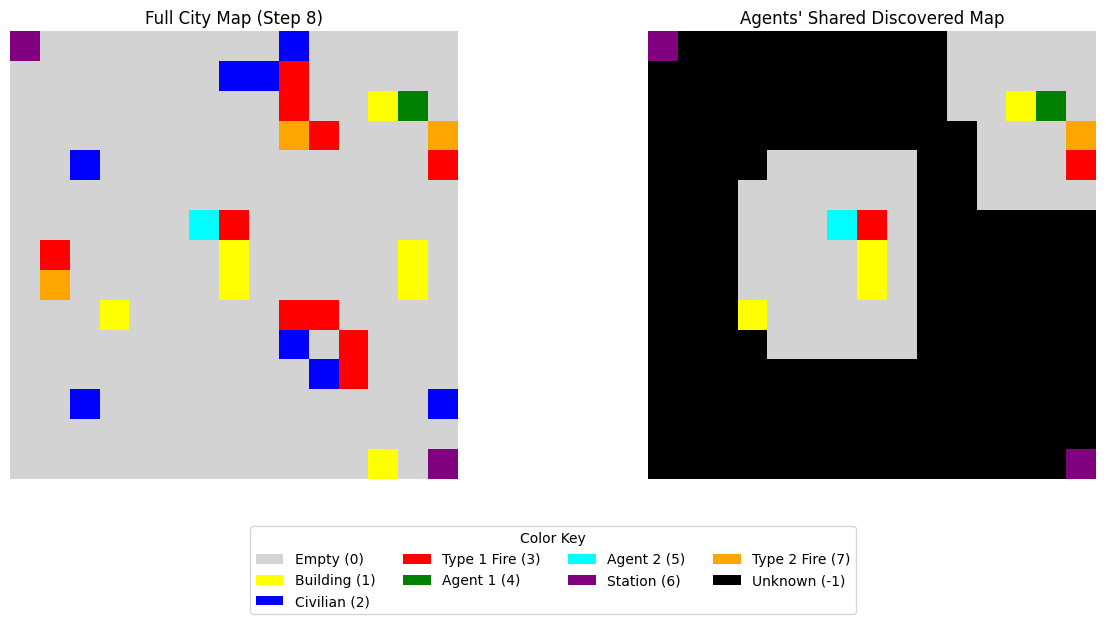

Step 8 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move up
Step 8 - Agent 2
LLM Action: extinguish fire
Reasoning: The agent is extinguishing the Type 1 fire it is currently on, following priority 3. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.
Agent 2 extinguished Type 1 fire! Score: 20


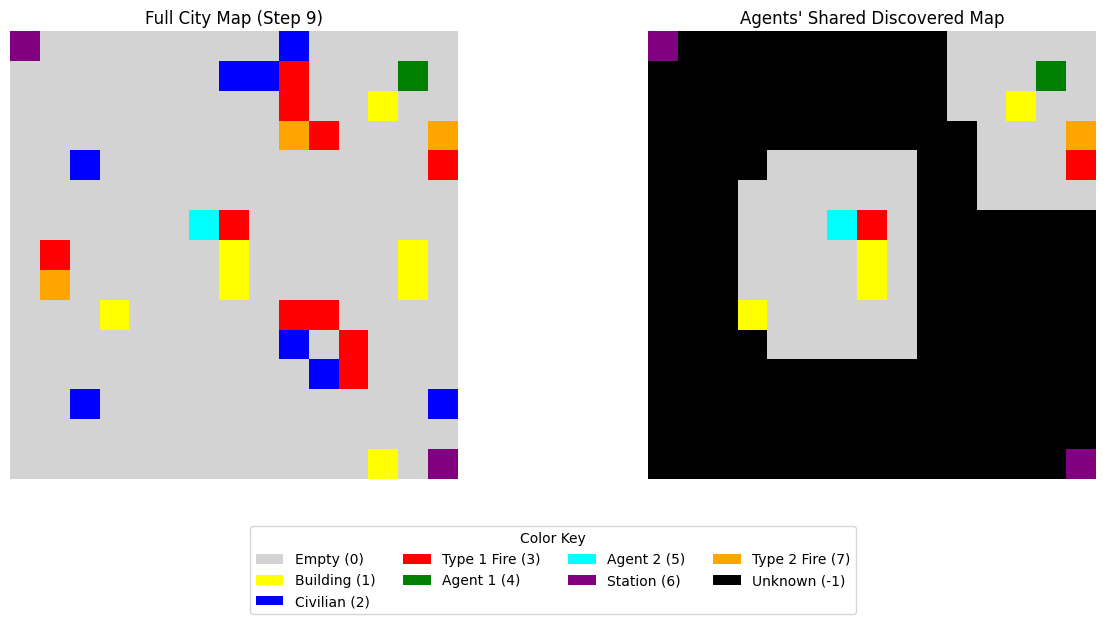

Step 9 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 9 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the Type 1 fire at position (6, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.
Civilian died in fire! Score: -80
Civilian died in fire! Score: -180


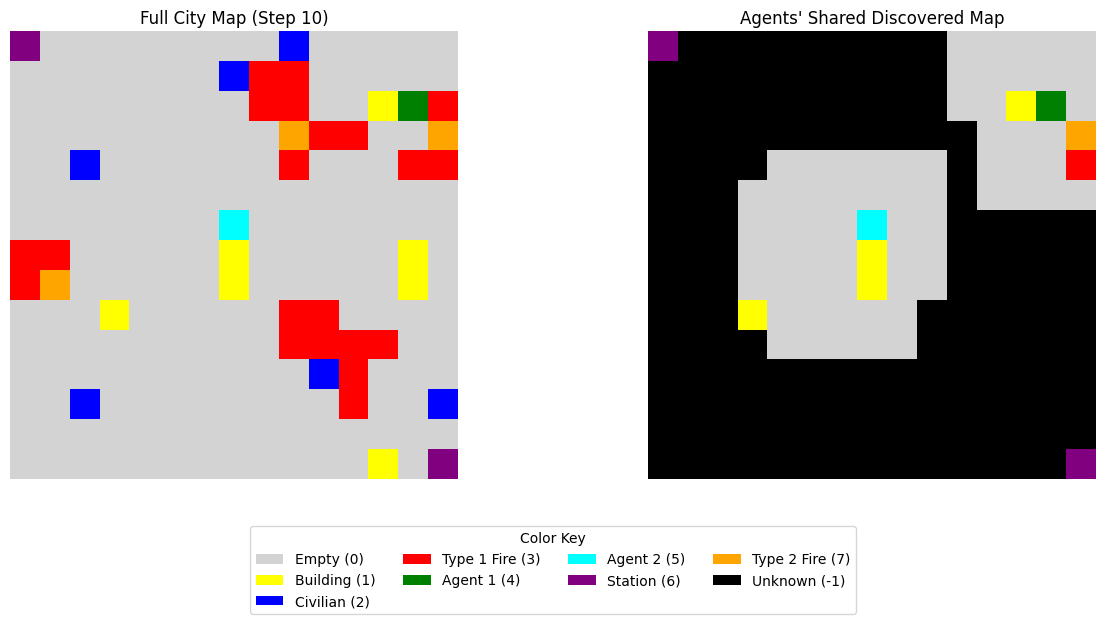

Step 10 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move up
Step 10 - Agent 2
LLM Action: move left
Reasoning: The agent is moving away from the Type 1 fire as it cannot extinguish it without another agent on the same cell. This action is chosen to avoid taking damage from the fire and to potentially find another target or move towards a known civilian or fire.


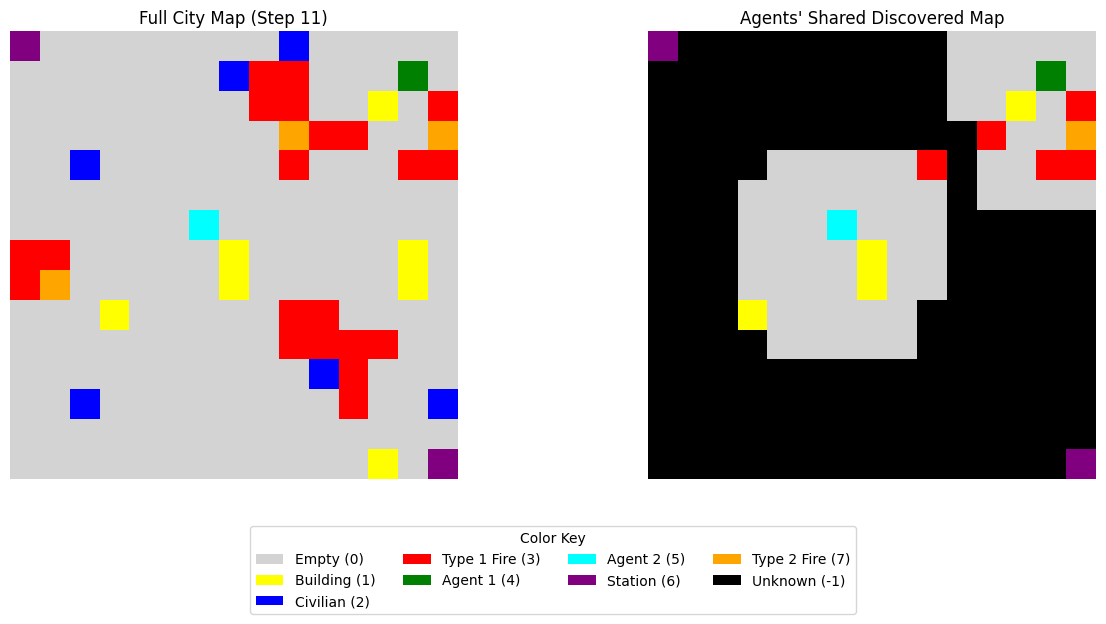

Step 11 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 11 - Agent 2
LLM Action: move right
Reasoning: The agent is moving towards the Type 1 fire at position (6, 7) to potentially extinguish it, following priority 5. This action is chosen because it directly addresses a known issue (the fire) and is in line with the agent's capabilities and priorities.


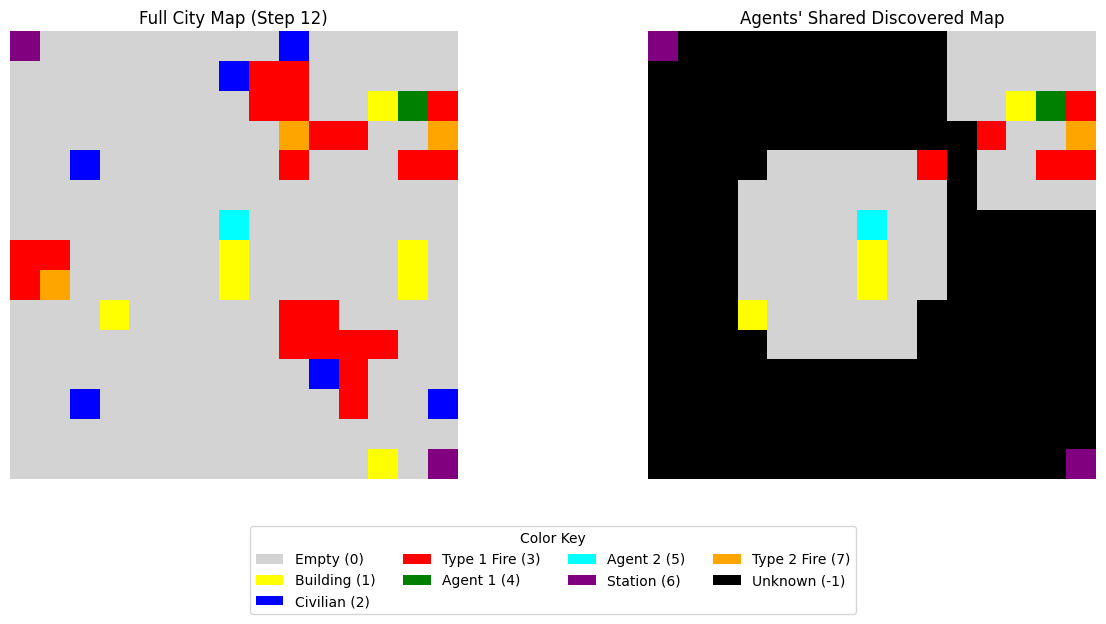

Step 12 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move up
Step 12 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the civilian at position (9, 7) to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.
Invalid action: move down. Choosing fallback action.
Fallback Action: move left


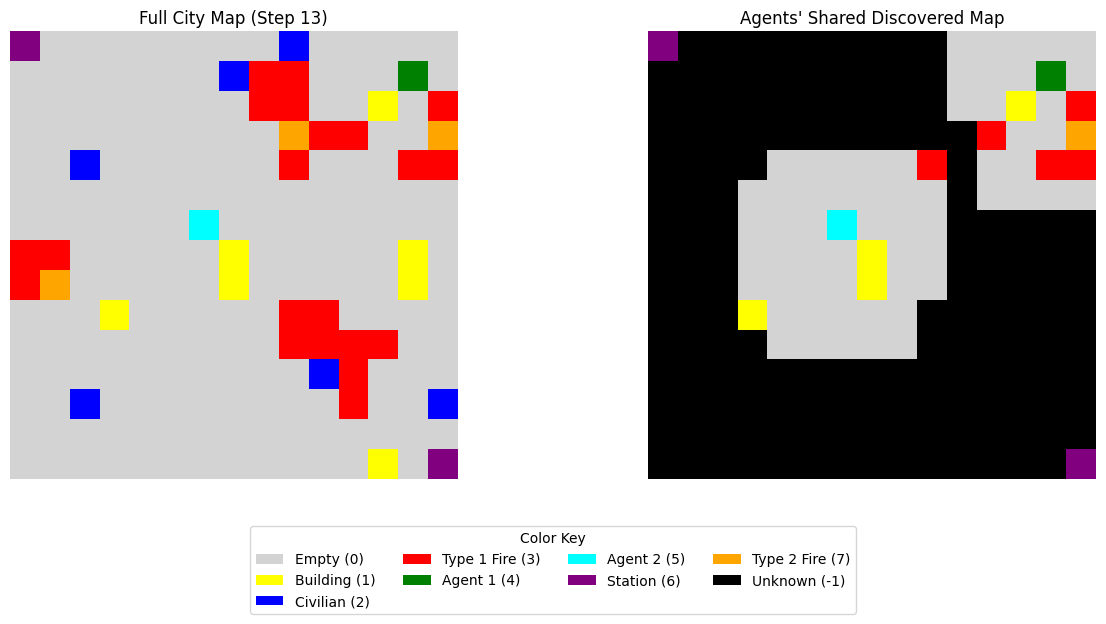

Step 13 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 13 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the area where the civilian at position (9, 7) might be to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.


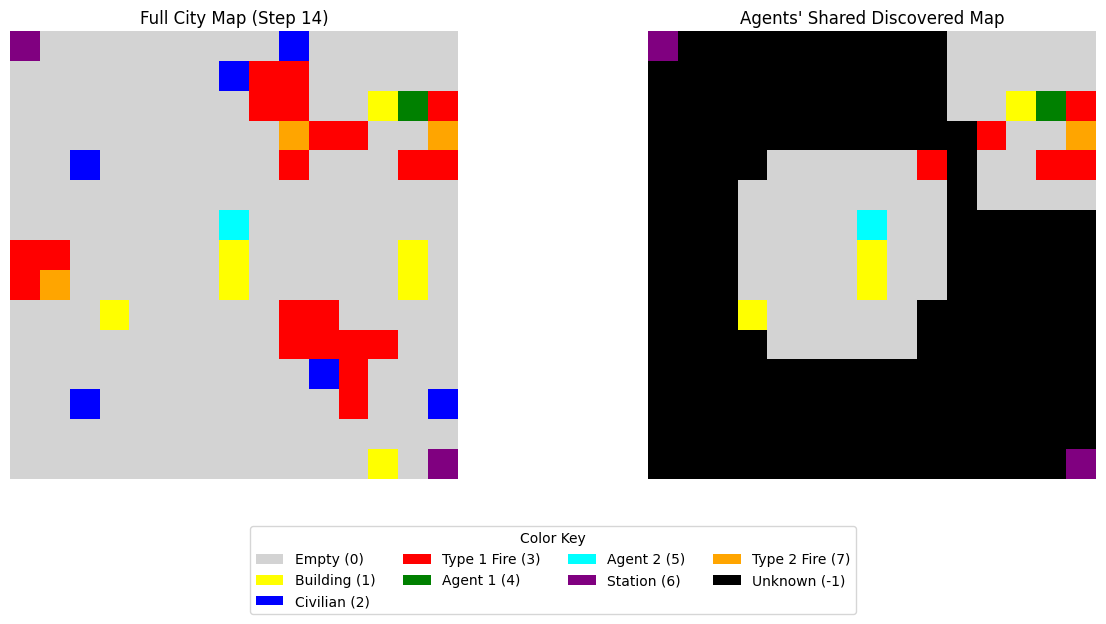

Step 14 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move right
Step 14 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the civilian at position (9, 7) to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.
Invalid action: move down. Choosing fallback action.
Fallback Action: move left
Civilian died in fire! Score: -280
Civilian died in fire! Score: -380


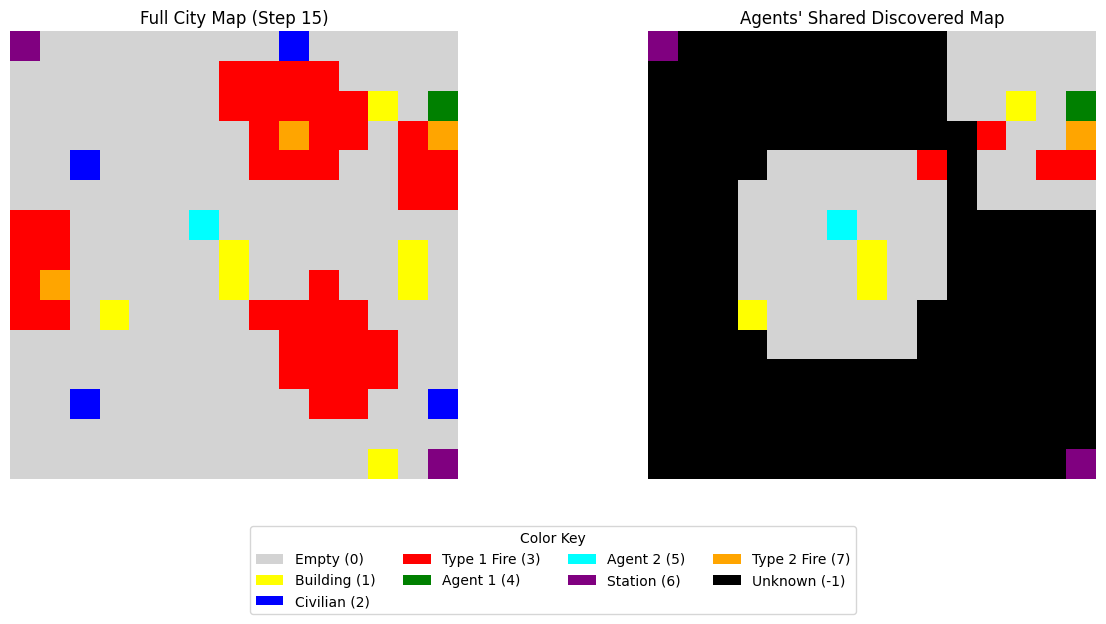

Step 15 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -370
Step 15 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the area where the civilian at position (9, 7) might be to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.


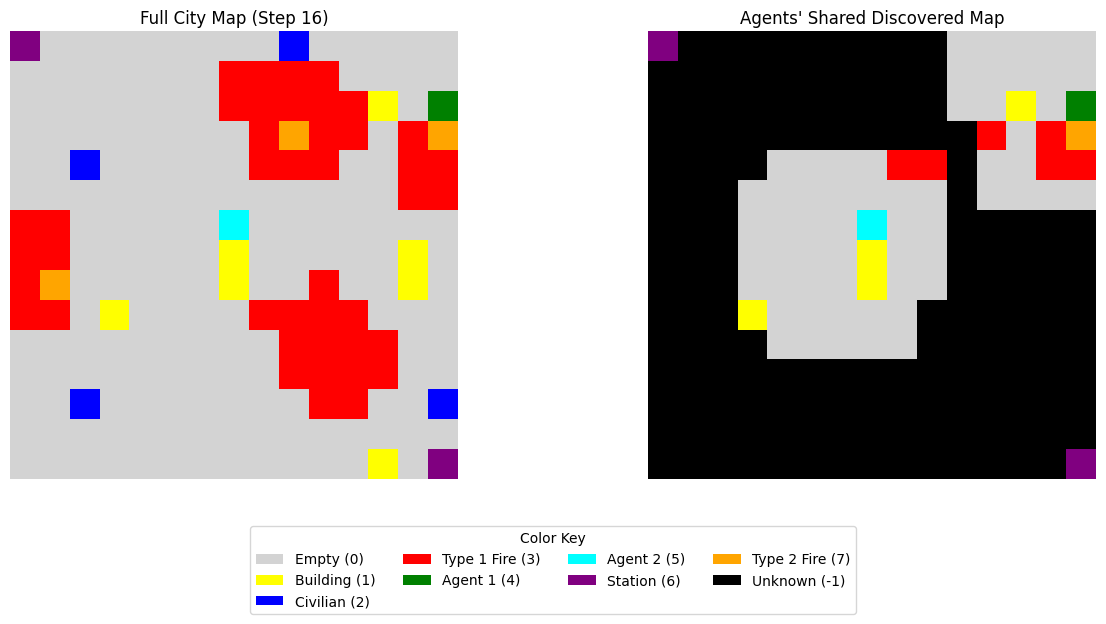

Step 16 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 16 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the civilian at position (9, 7) to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.
Invalid action: move down. Choosing fallback action.
Fallback Action: move right


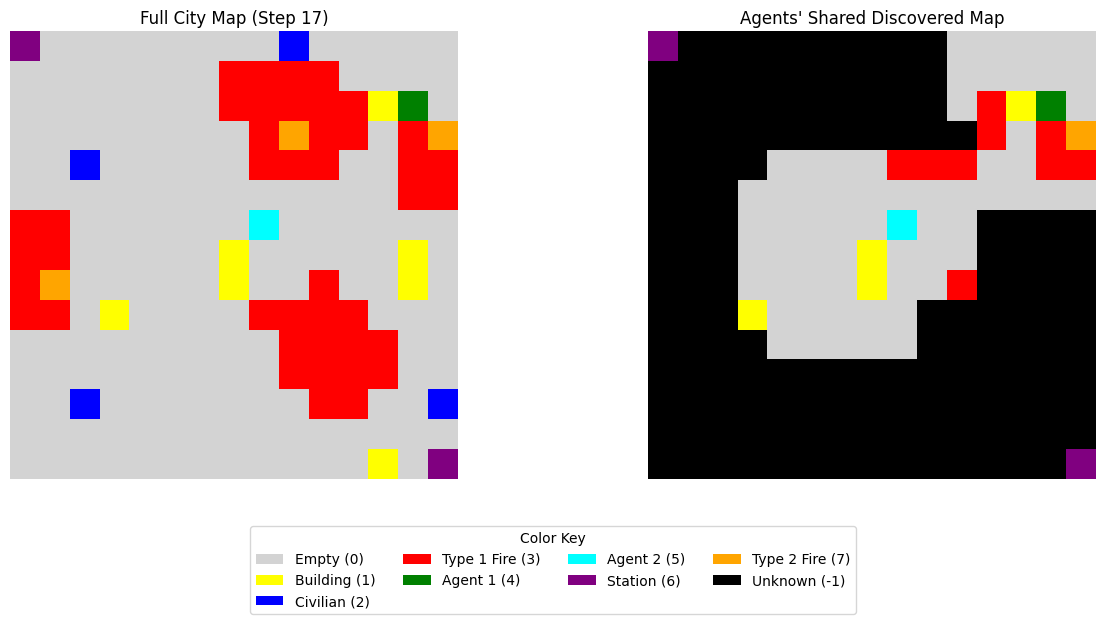

Step 17 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move up
Step 17 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the civilian at position (9, 7) to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.


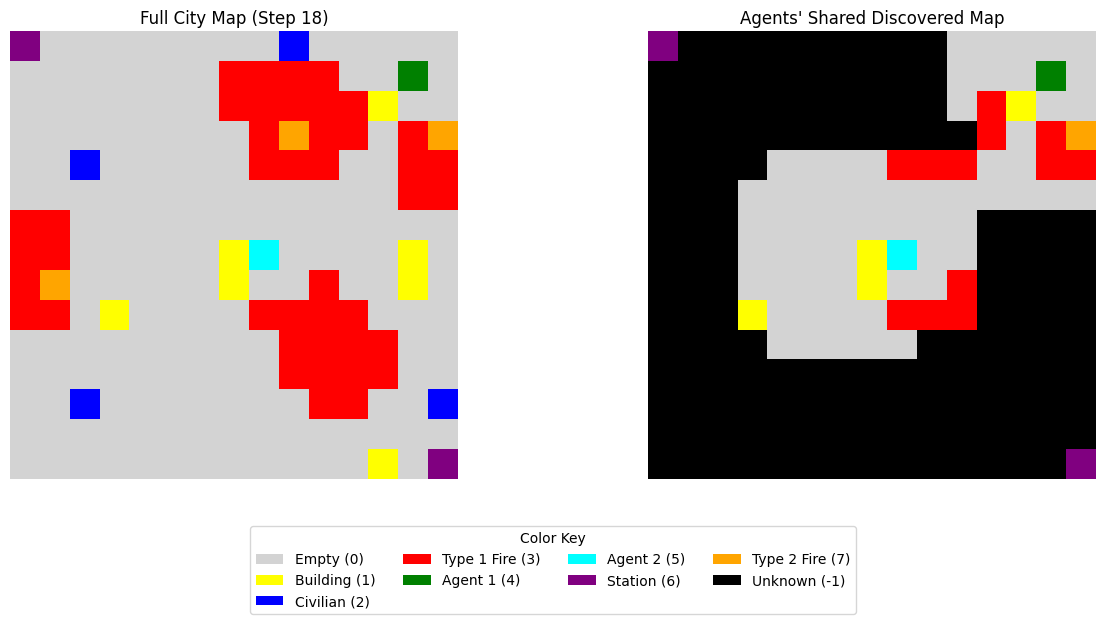

Step 18 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 18 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the civilian at position (9, 7) to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.


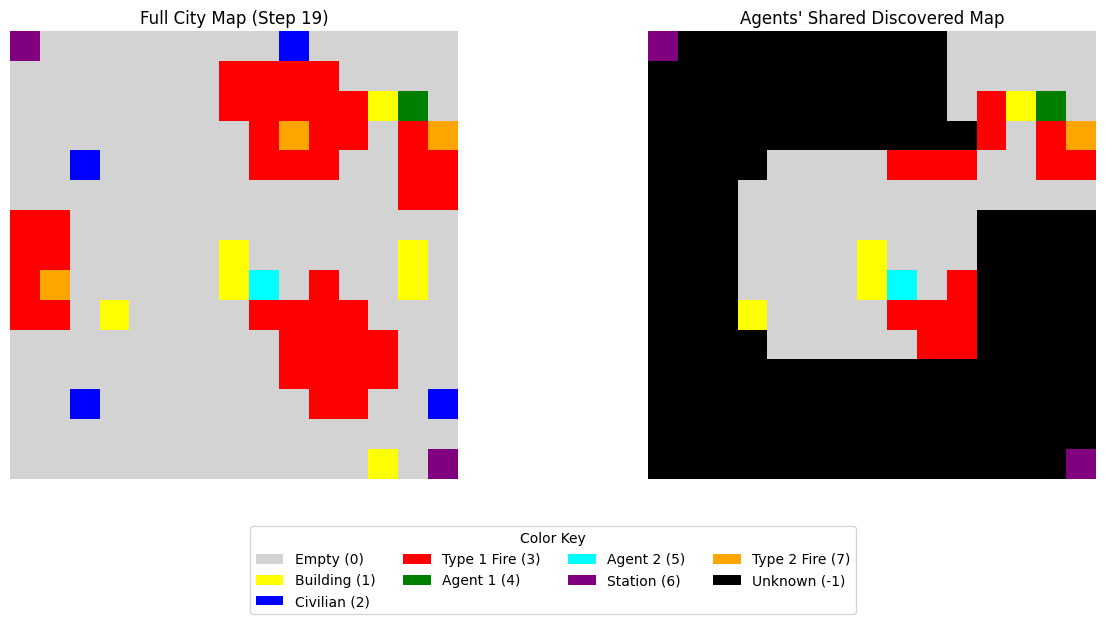

Step 19 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move up
Step 19 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the civilian at position (9, 7) to potentially rescue it, following priority 4. This action is chosen because it moves the agent closer to a known target and is in line with the agent's capabilities and priorities.
Civilian died in fire! Score: -470


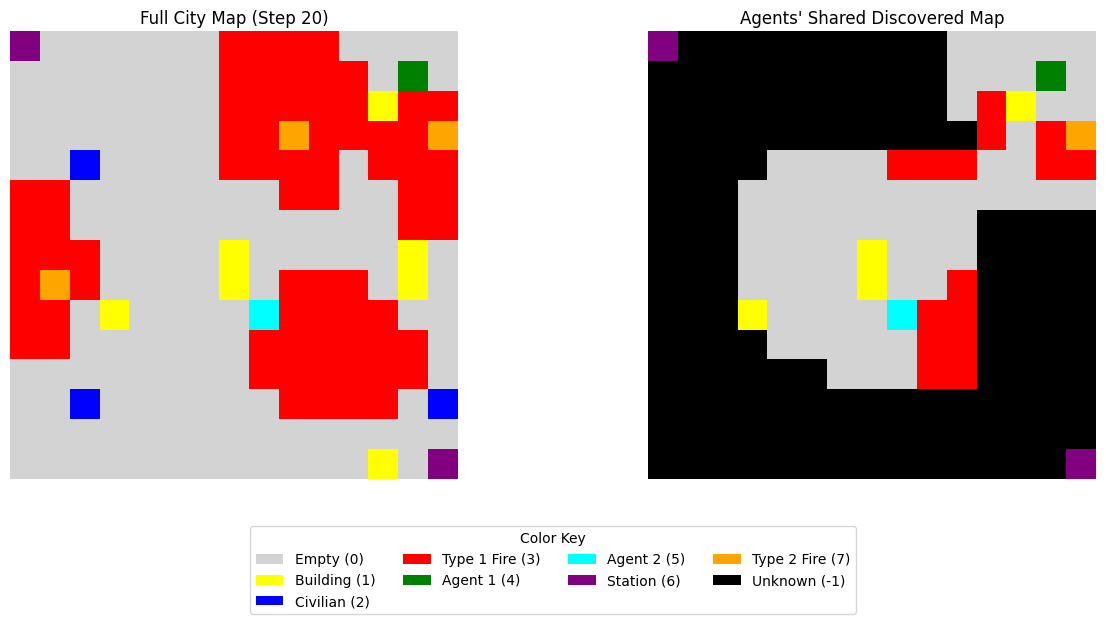

Step 20 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 20 - Agent 2
LLM Action: move left
Reasoning: The agent is moving away from the Type 1 fire as it cannot extinguish it without another agent on the same cell. This action is chosen to avoid taking damage from the fire and to potentially find another target or move towards a known civilian.


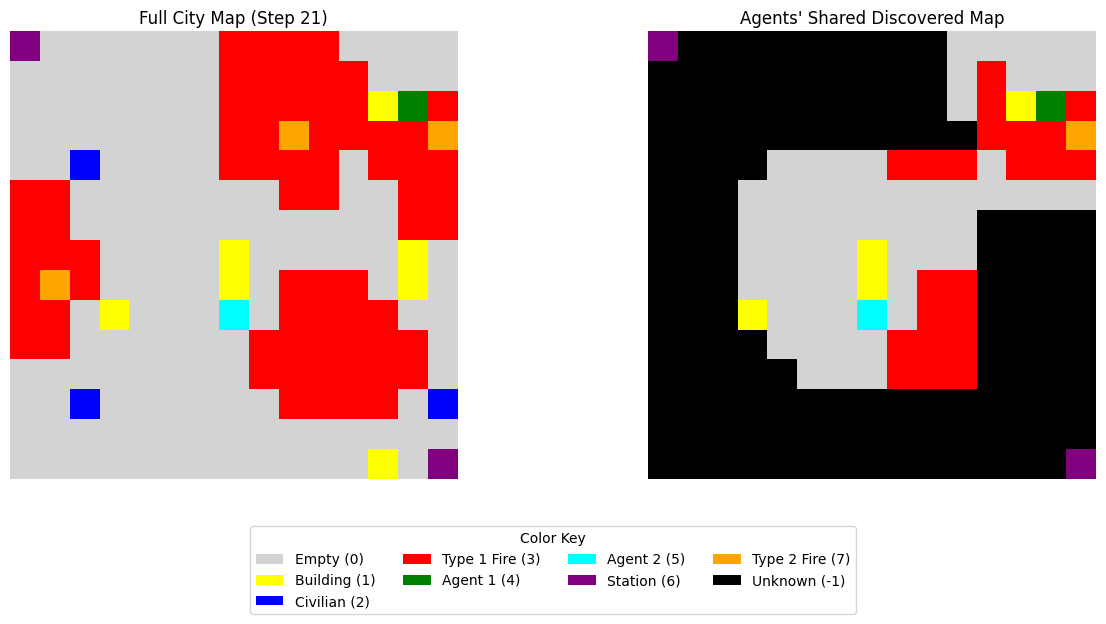

Step 21 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -460
Step 21 - Agent 2
LLM Action: rescue civilian
Reasoning: The agent is rescuing the civilian it is currently on, following priority 2. This action is chosen because it directly addresses a known target and is in line with the agent's capabilities and priorities.
Invalid action: rescue civilian. Choosing fallback action.
Fallback Action: move down


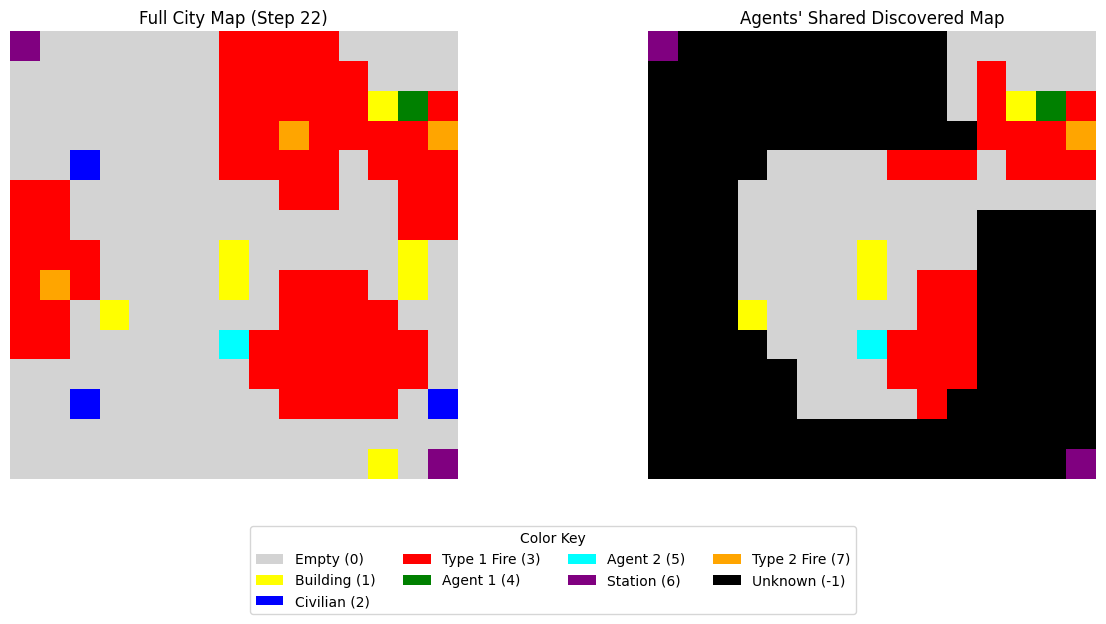

Step 22 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move up
Step 22 - Agent 2
LLM Action: move up
Reasoning: The agent is moving up to position (9, 7) to potentially move closer to the area where it was before and to other areas of interest, following priority 7. This action is chosen because it moves the agent closer to a known area and is in line with the agent's capabilities and priorities.


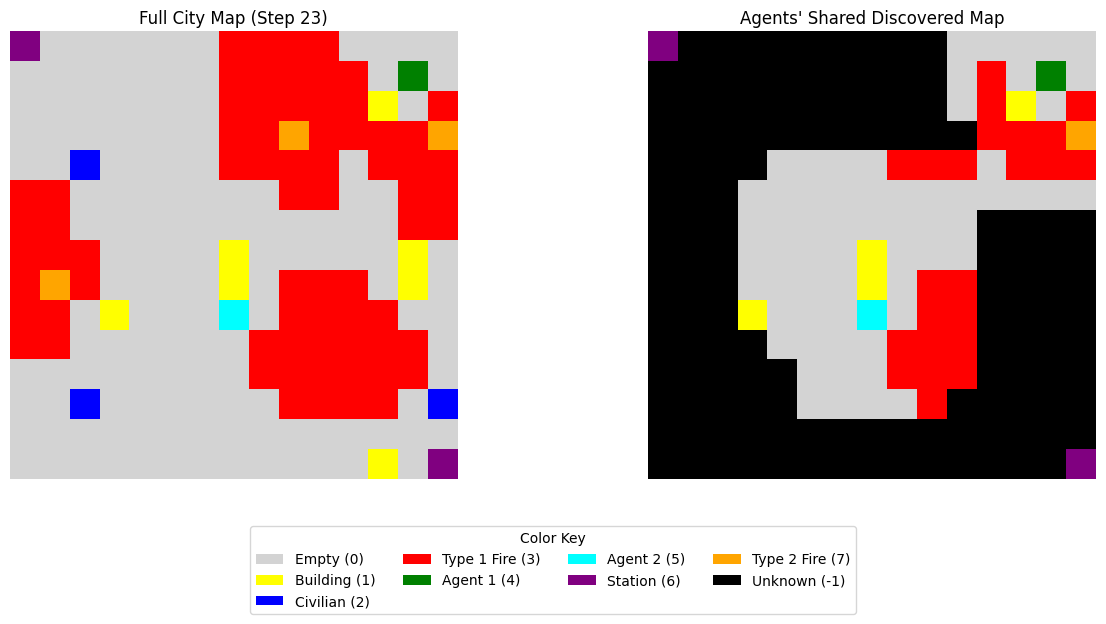

Step 23 - Agent 1
LLM Action: move down
Reasoning: The agent should move down because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 23 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


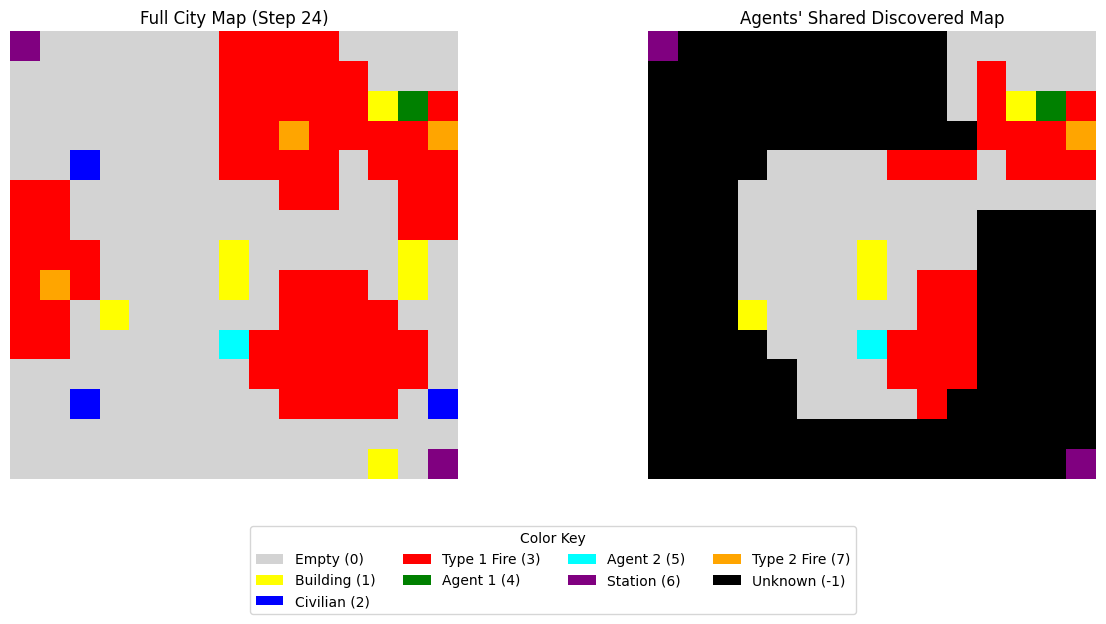

Step 24 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 24 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


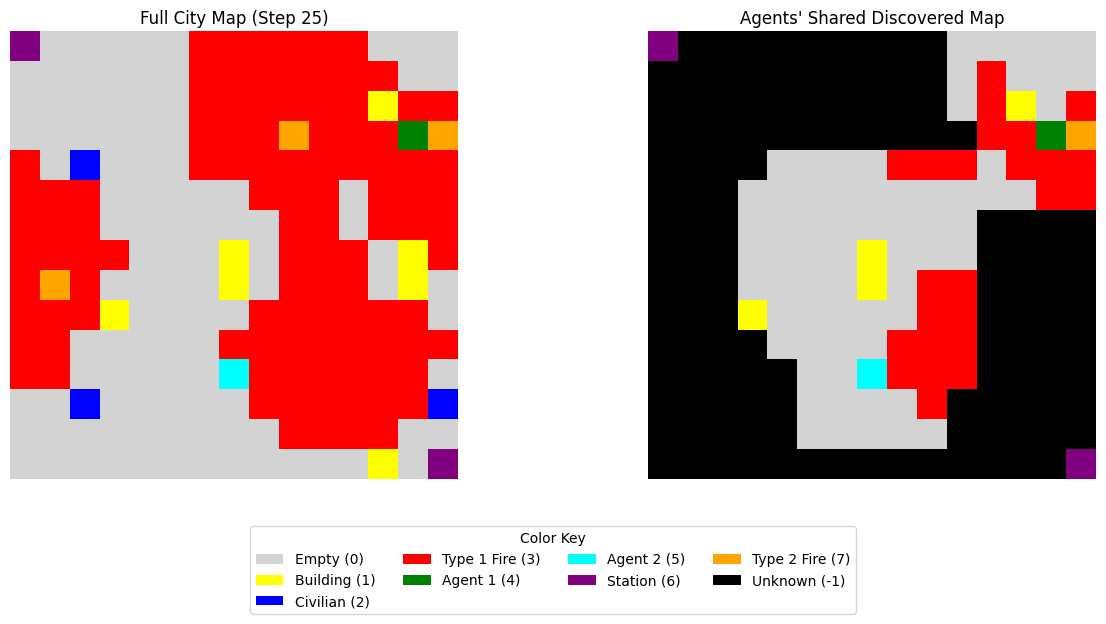

Step 25 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -450
Step 25 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


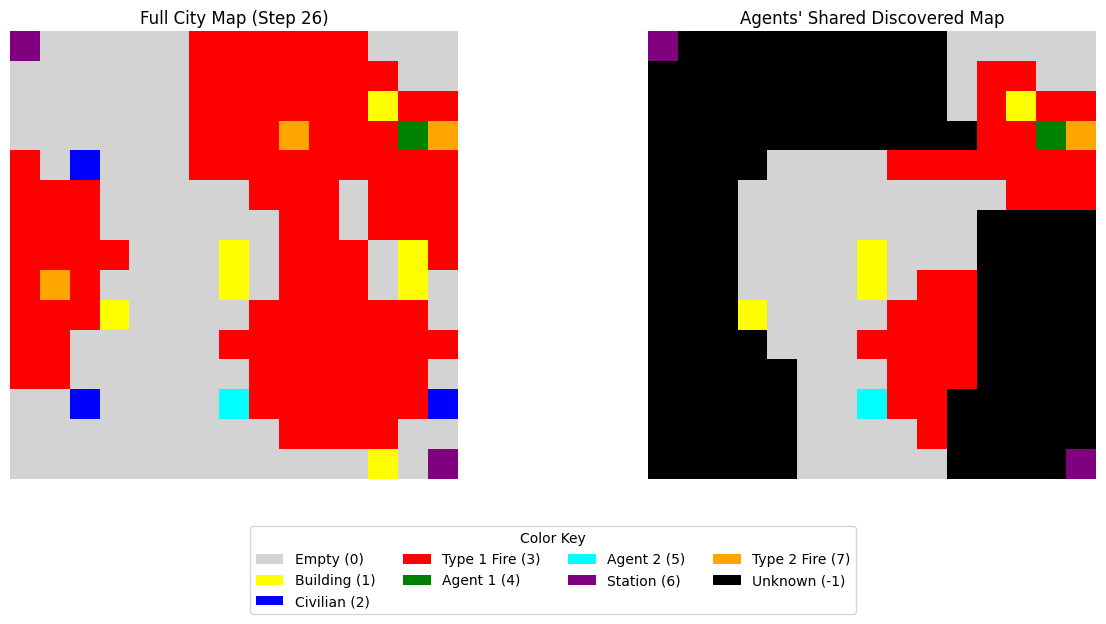

Step 26 - Agent 1
LLM Action: move up
Reasoning: The agent should move up because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 26 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


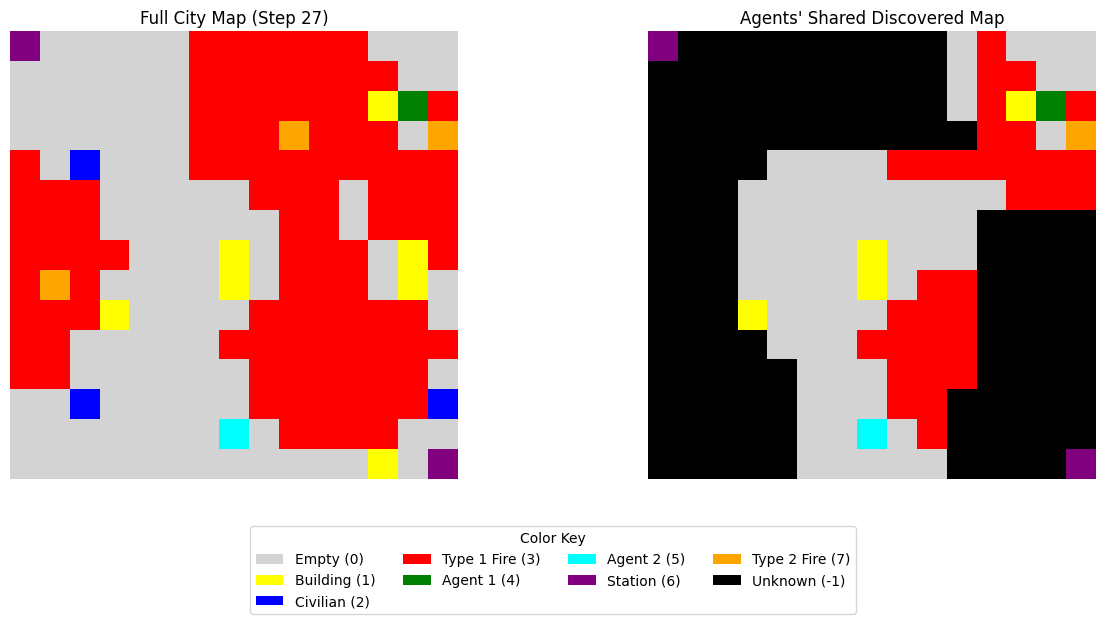

Step 27 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -440
Step 27 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


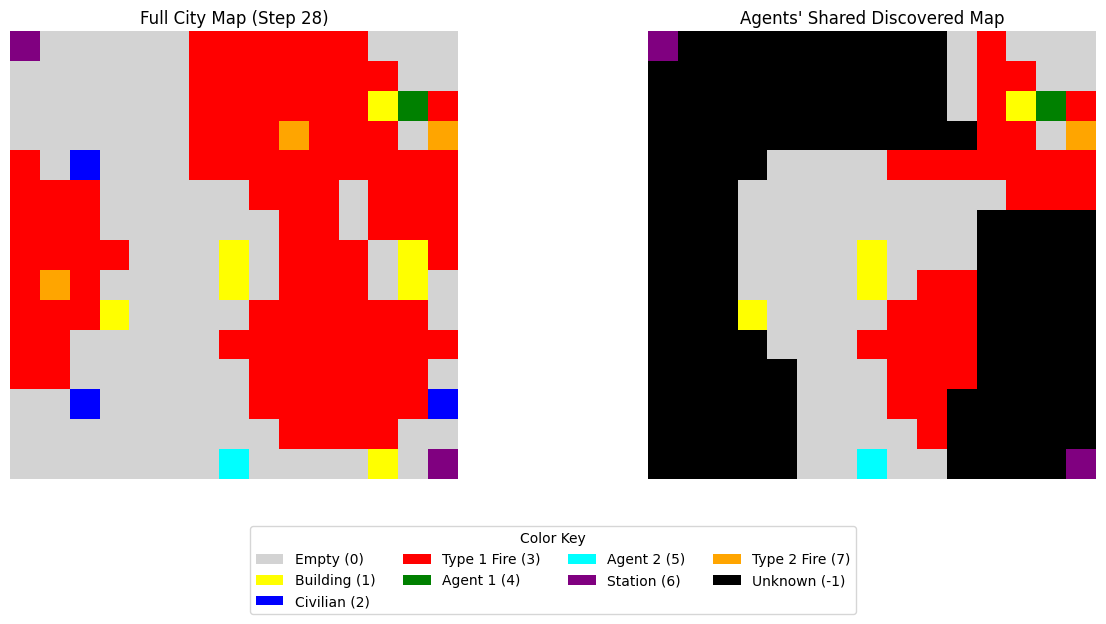

Step 28 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move right
Step 28 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


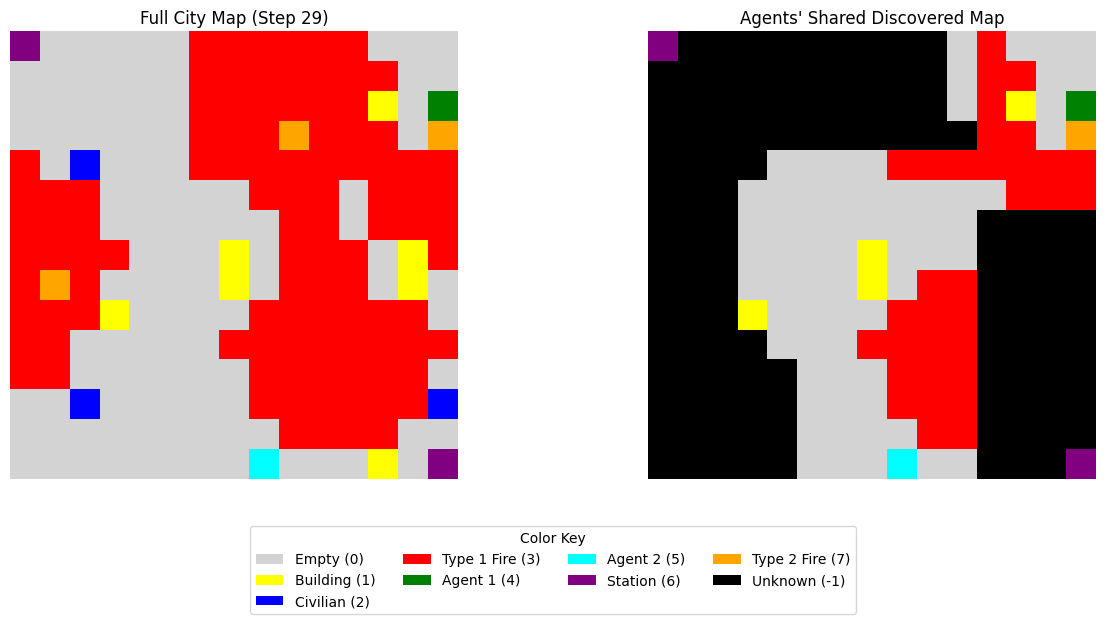

Step 29 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -430
Step 29 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Civilian died in fire! Score: -530
Civilian died in fire! Score: -630


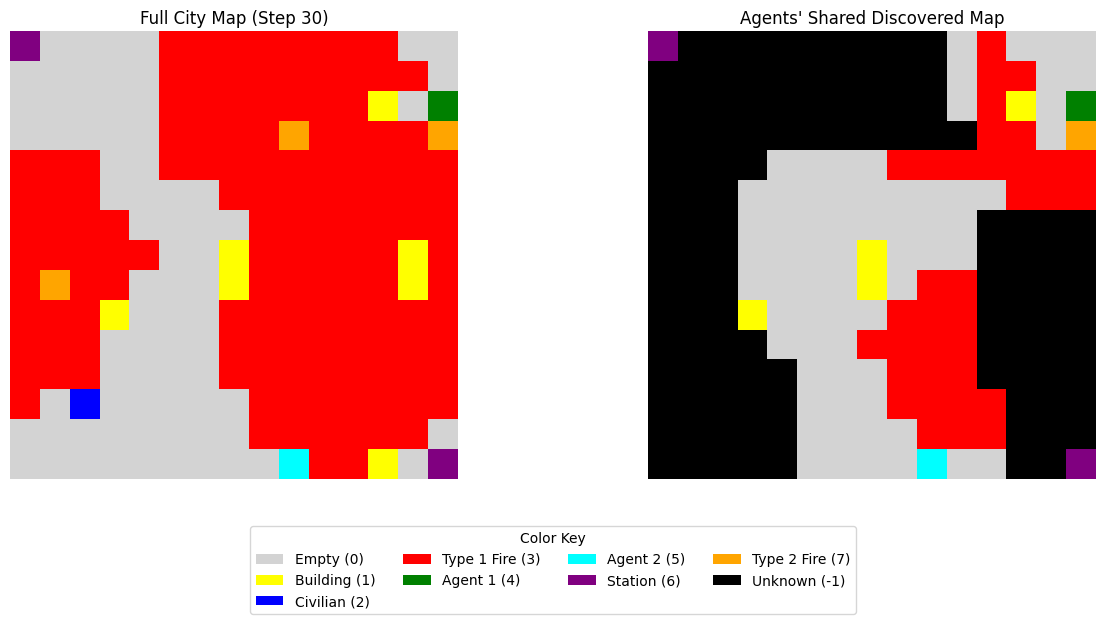

Step 30 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 30 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


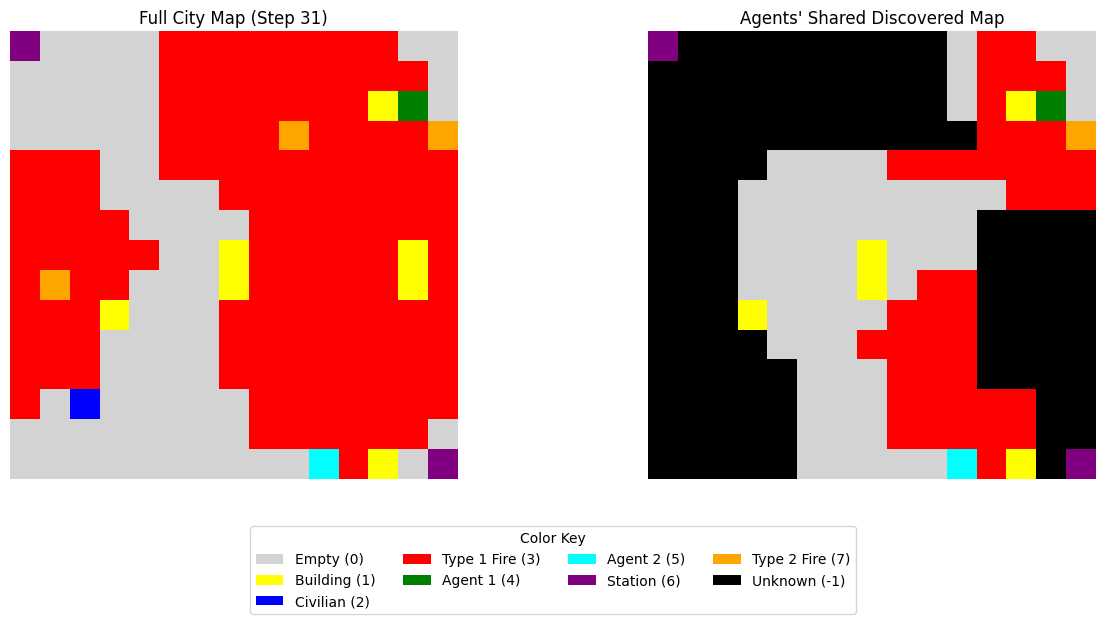

Step 31 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 31 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


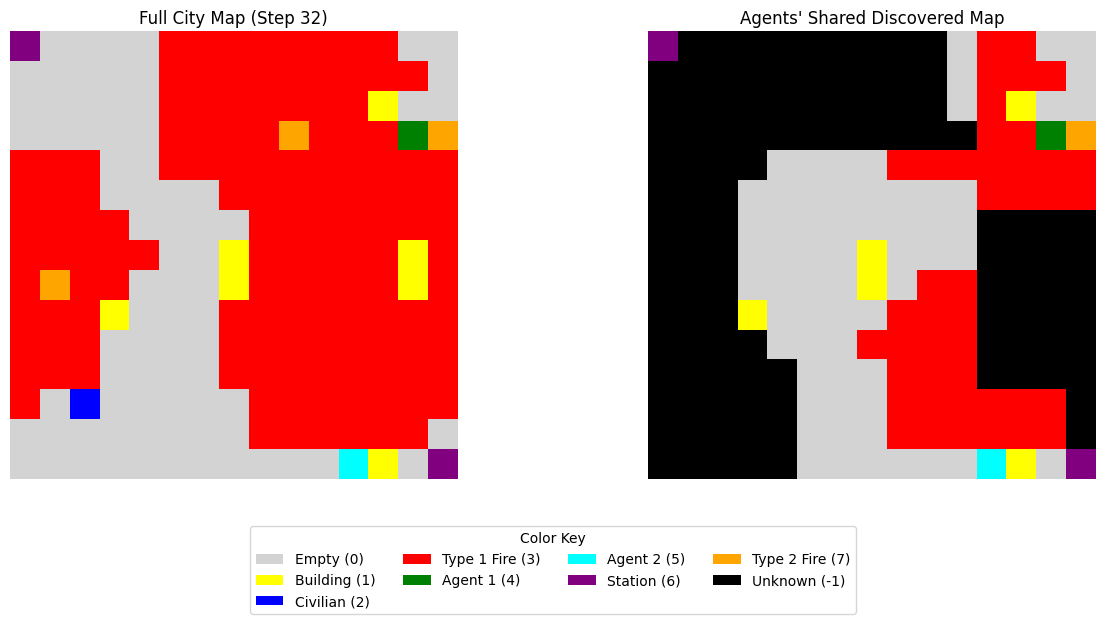

Step 32 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -620
Step 32 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


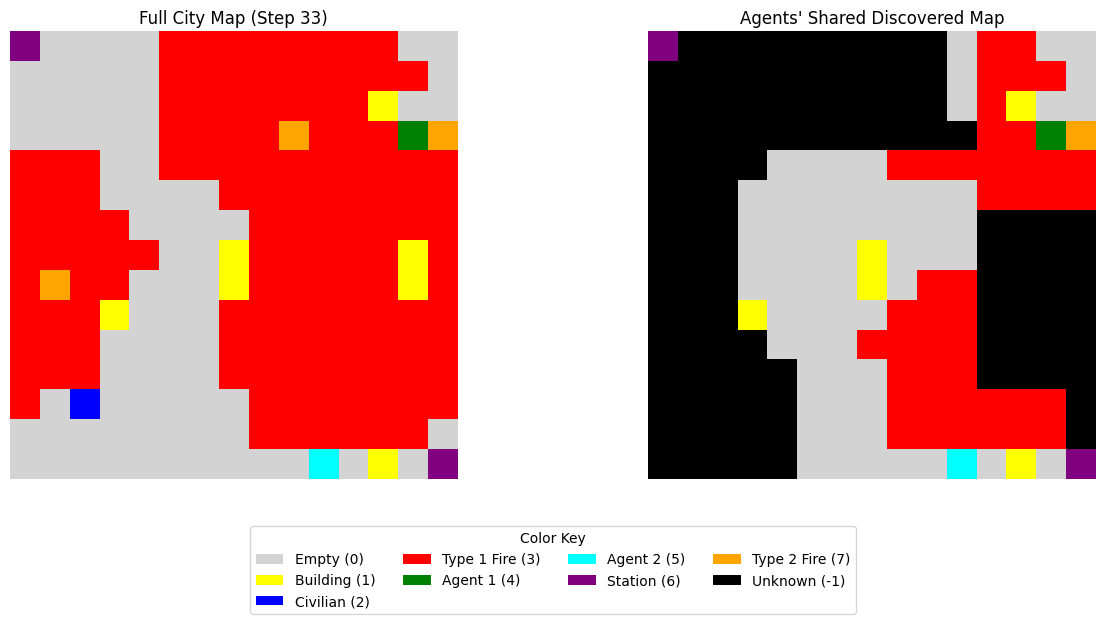

Step 33 - Agent 1
LLM Action: move up
Reasoning: The agent should move up because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 33 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


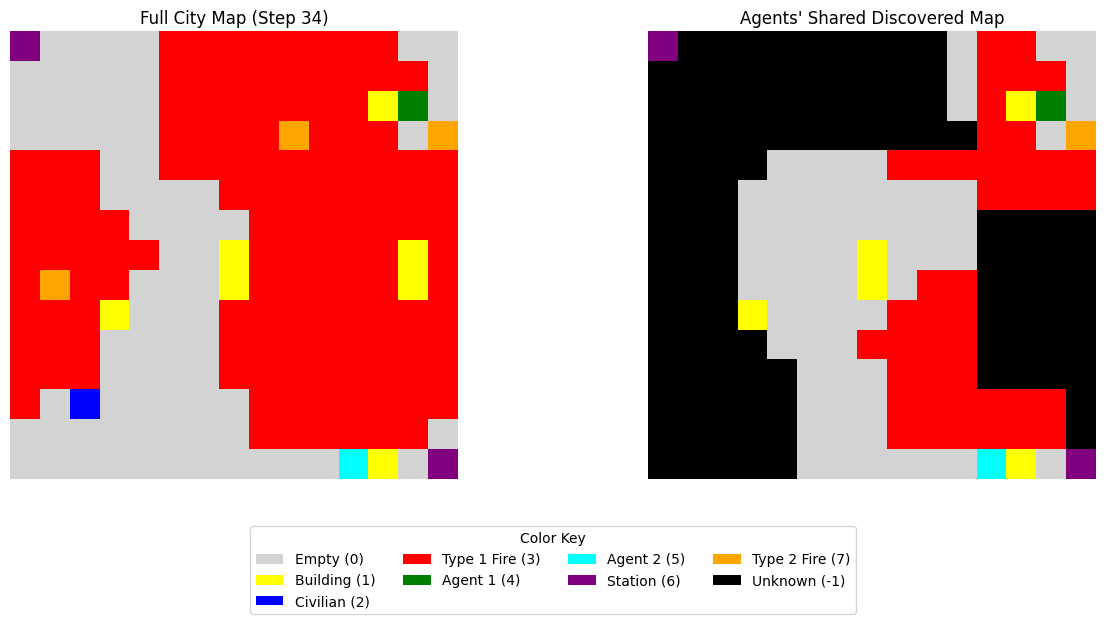

Step 34 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 34 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


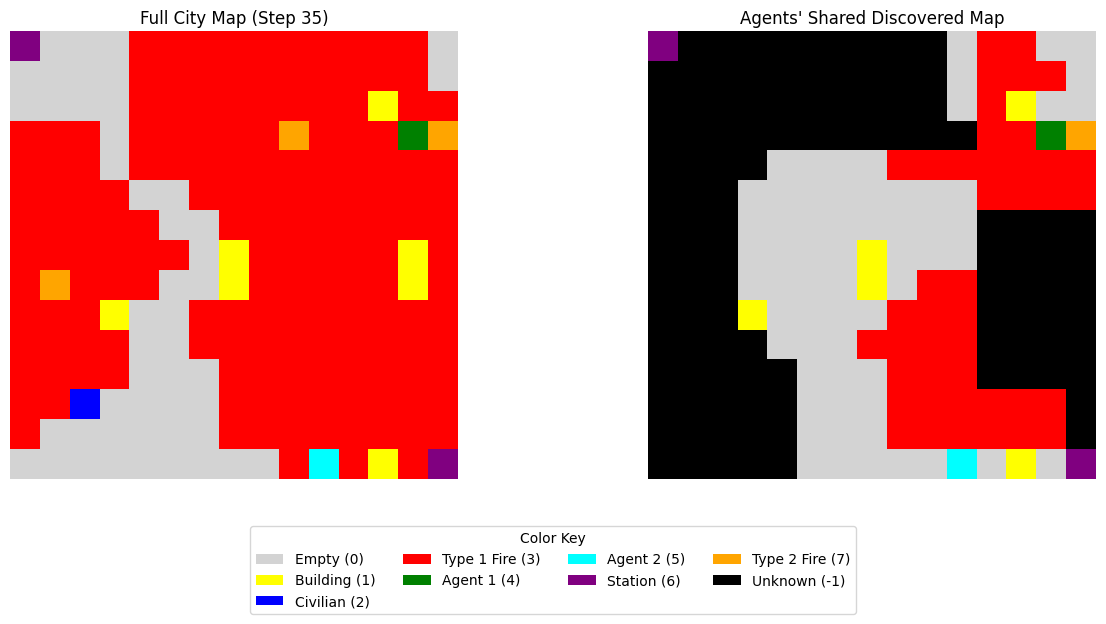

Step 35 - Agent 1
LLM Action: move up
Reasoning: The agent should move up because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 35 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


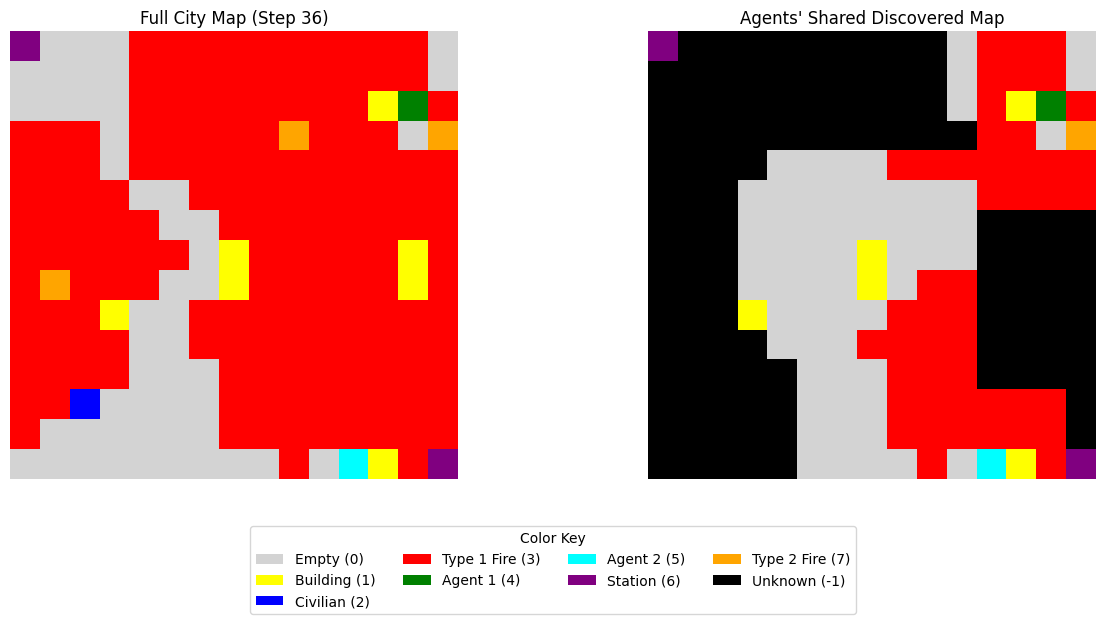

Step 36 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -610
Step 36 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


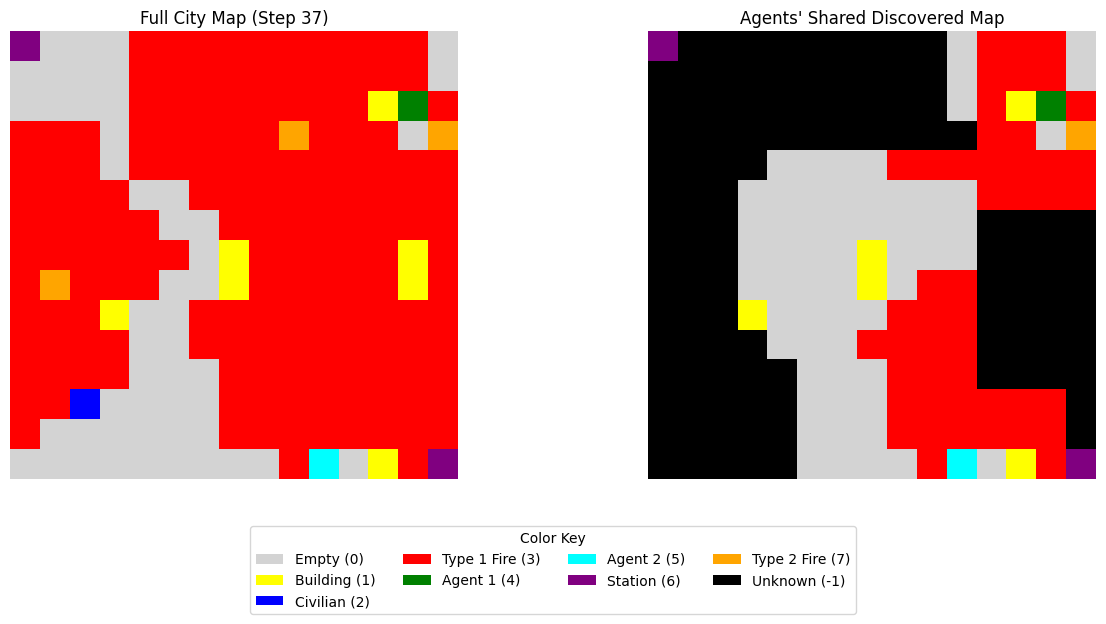

Step 37 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 37 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


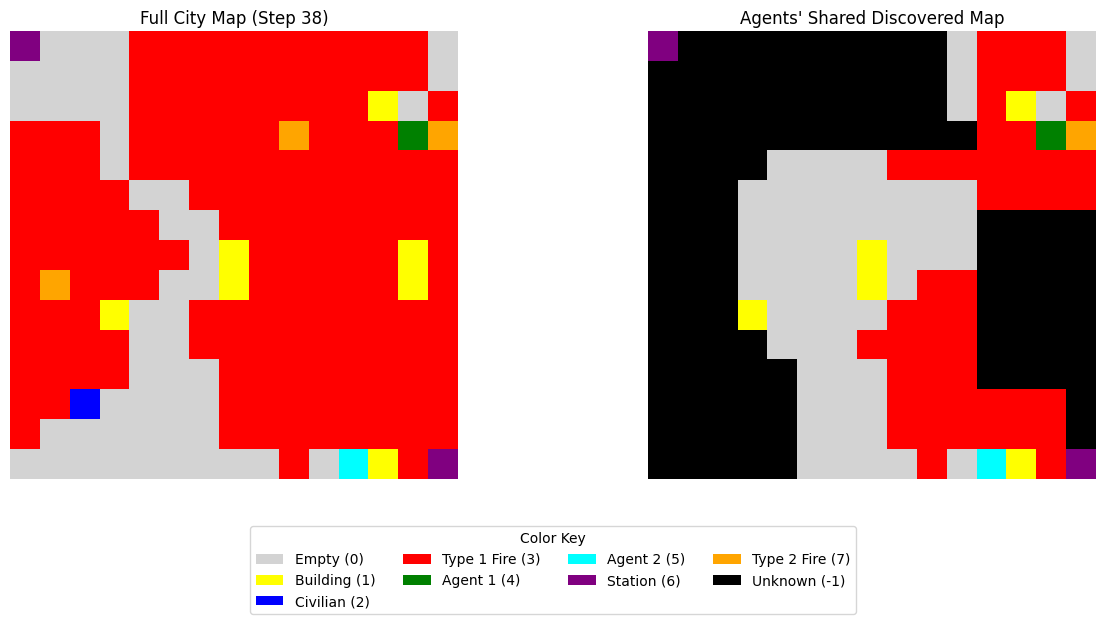

Step 38 - Agent 1
LLM Action: move up
Reasoning: The agent should move up because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 38 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move up


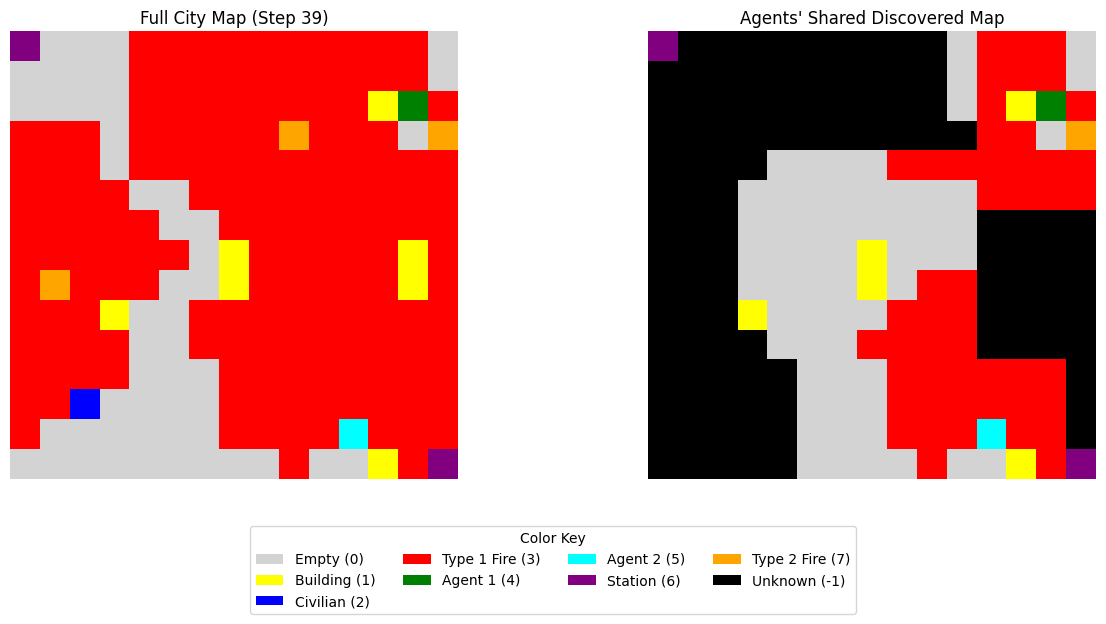

Step 39 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 39 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Civilian died in fire! Score: -710


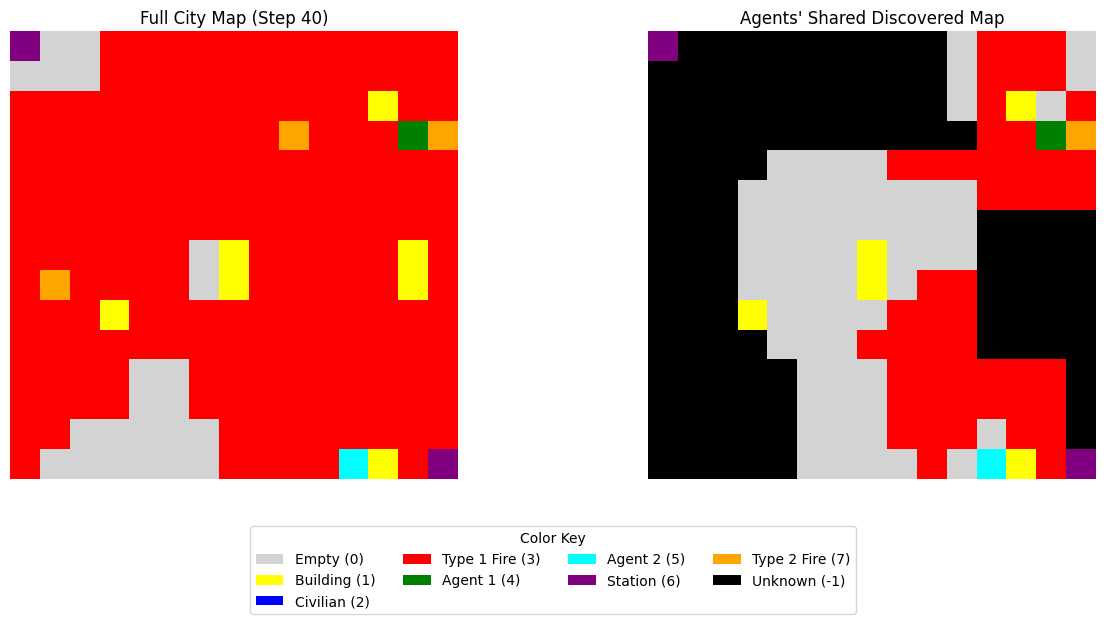

Step 40 - Agent 1
LLM Action: move up
Reasoning: The agent should move up because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 40 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


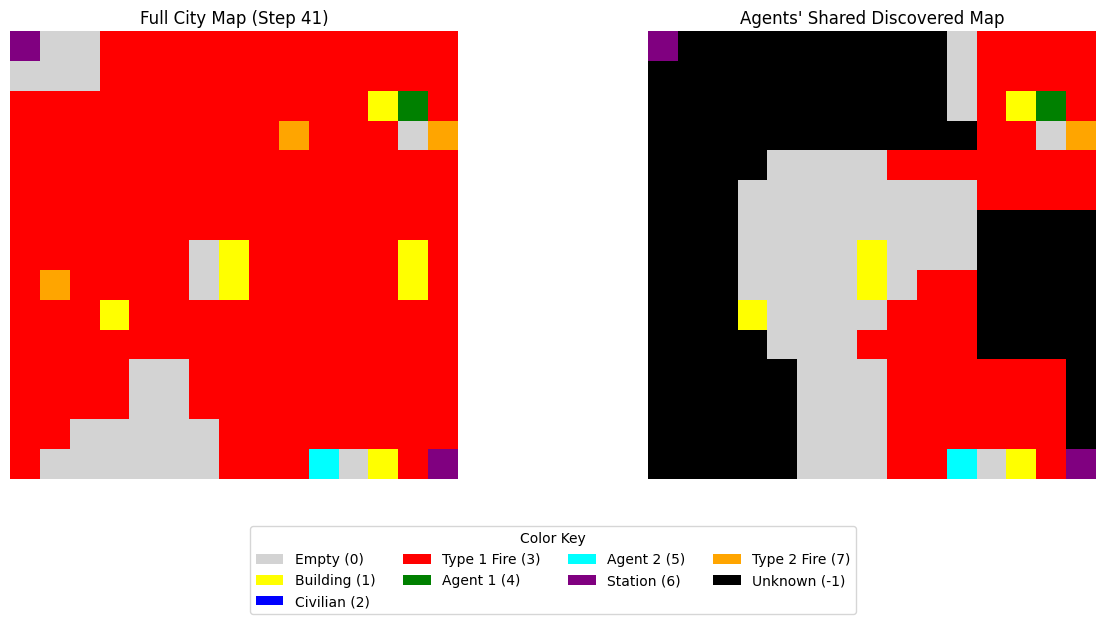

Step 41 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -700
Step 41 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


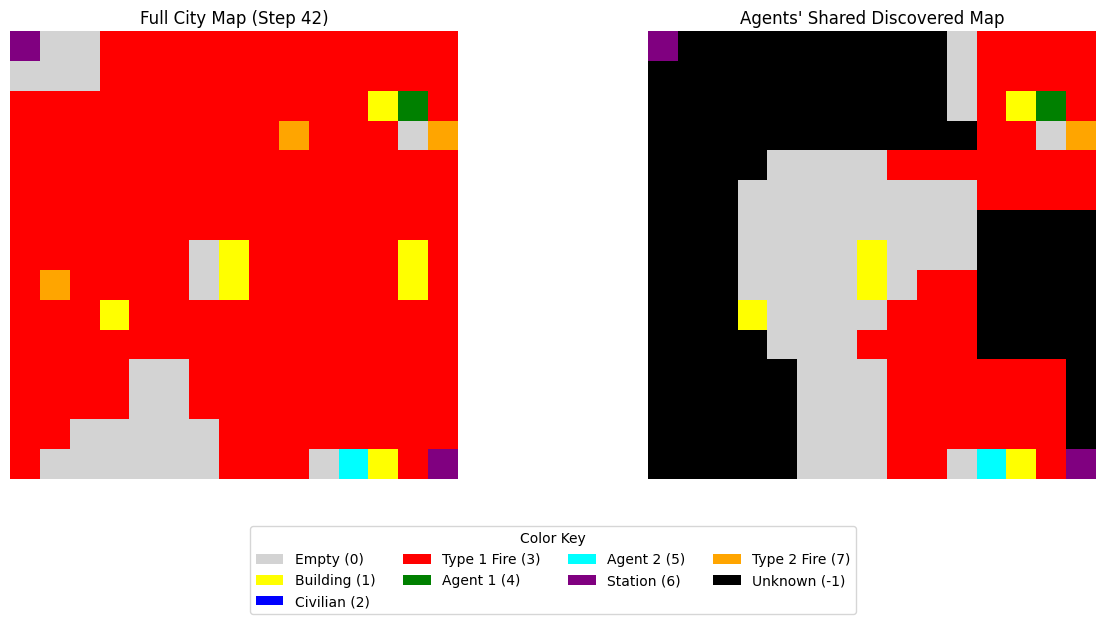

Step 42 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move right
Step 42 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move up


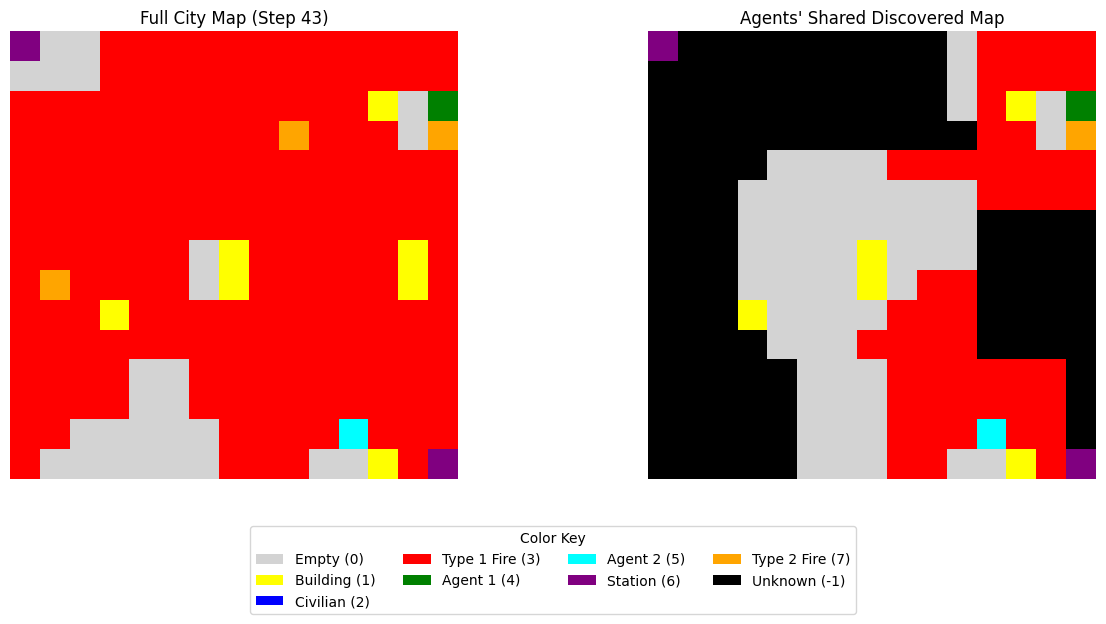

Step 43 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -690
Step 43 - Agent 2
LLM Action: move down
Reasoning: The agent is moving down towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


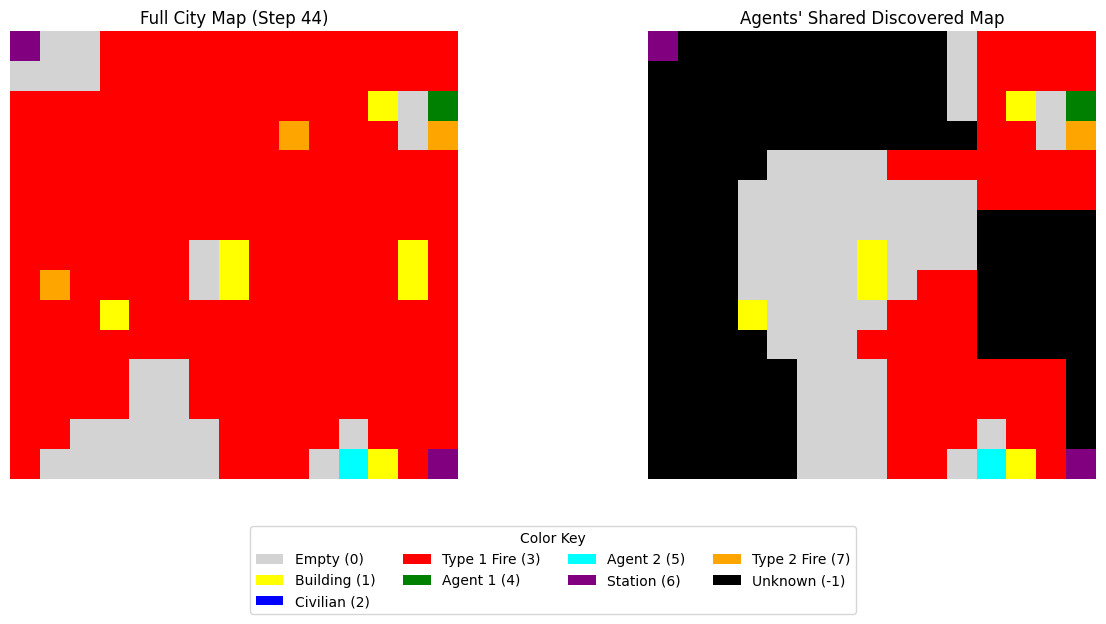

Step 44 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 44 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


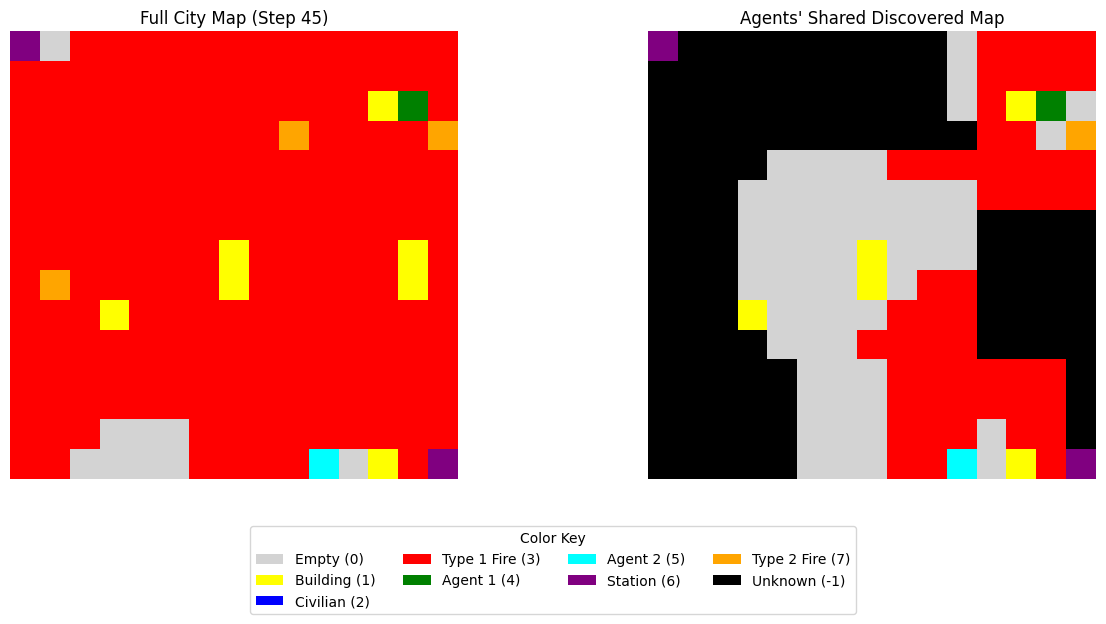

Step 45 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move right
Step 45 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


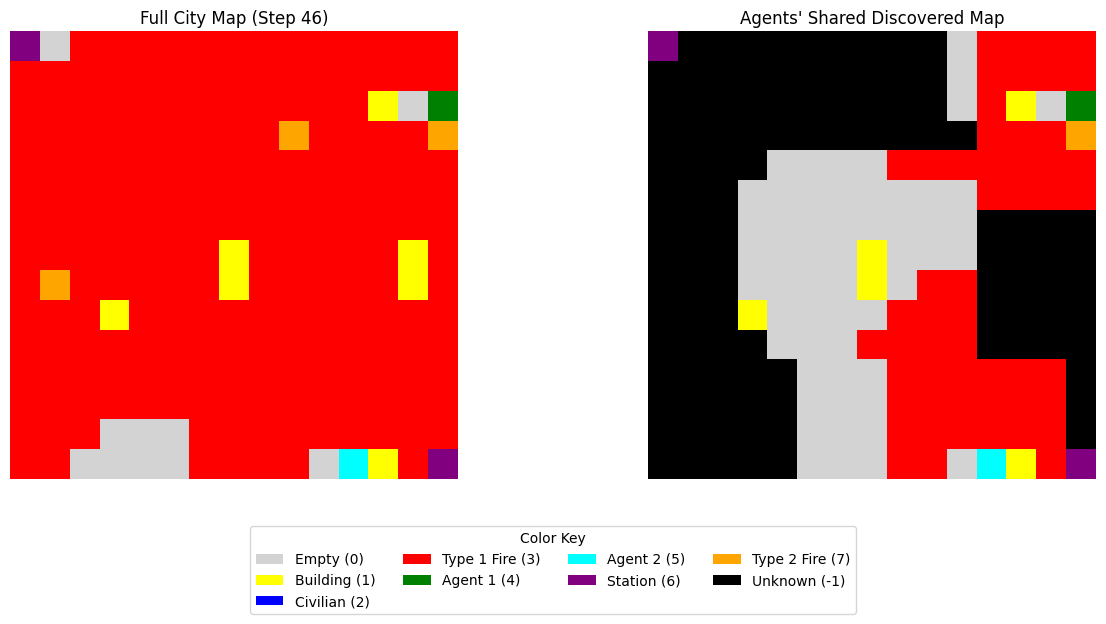

Step 46 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -680
Step 46 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


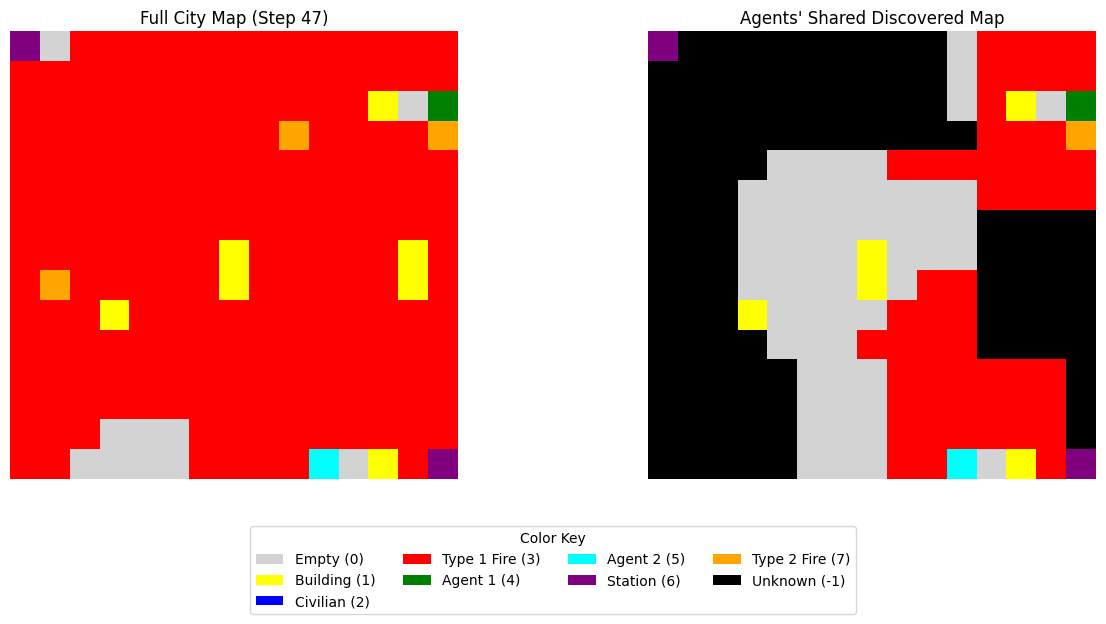

Step 47 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because it will bring the agent closer to the civilian at position (2, 12). This action is a step towards rescuing the civilian, which follows priority 2, and is the most direct and immediate goal based on the shared map.
Step 47 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


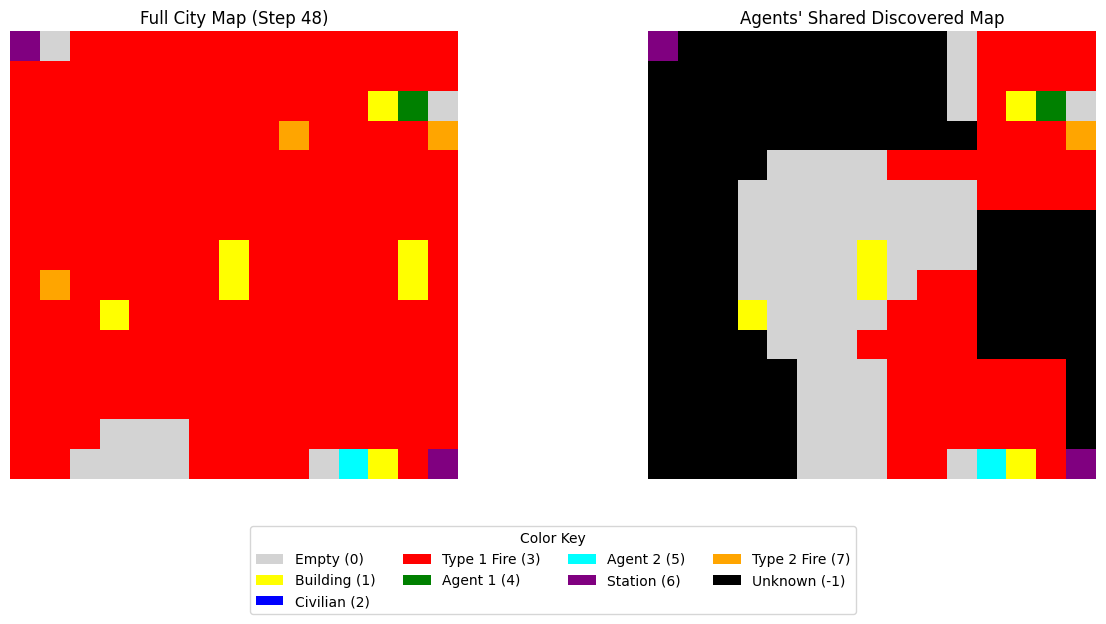

Step 48 - Agent 1
LLM Action: move left
Reasoning: The agent should move left because there is a civilian at position (2, 12), which is directly to the left of the agent's current position. This action follows priority 2, rescue a civilian if on their position and Carrying Civilian is No, and is the most direct and immediate goal based on the shared map.
Invalid action: move left. Choosing fallback action.
Fallback Action: move down
Step 48 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.
Invalid action: move right. Choosing fallback action.
Fallback Action: move left


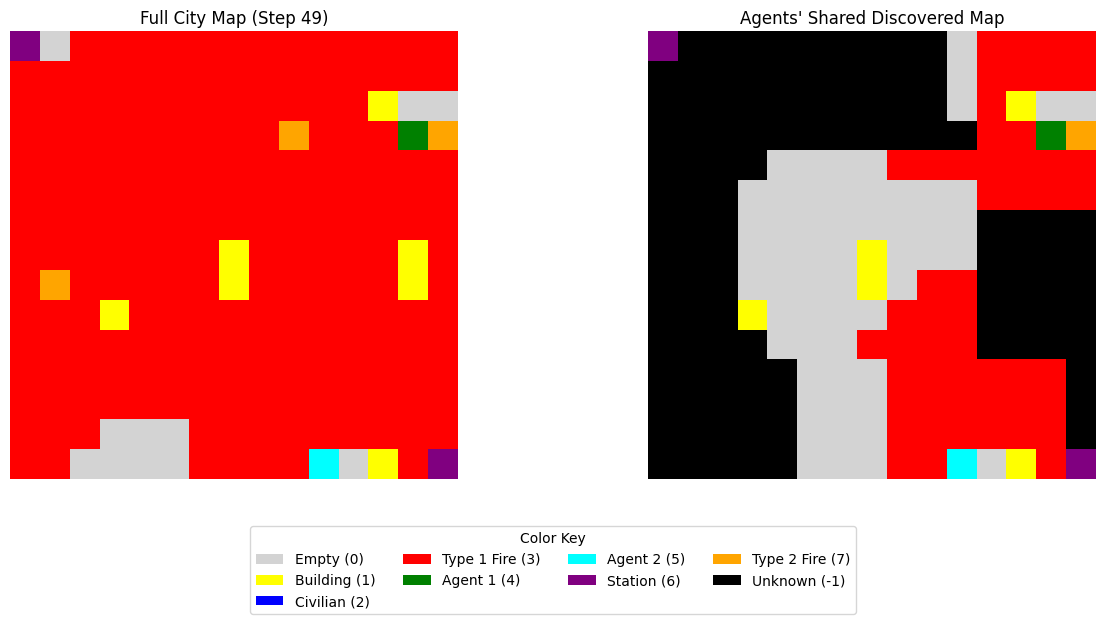

Step 49 - Agent 1
LLM Action: extinguish fire
Reasoning: The agent is currently on a Type 1 fire, which aligns with priority 3, extinguish a Type 1 fire if on its position. This is the most direct and immediate action the agent can take based on its current position and the shared map.
Agent 1 extinguished Type 1 fire! Score: -670
Step 49 - Agent 2
LLM Action: move right
Reasoning: The agent is moving right towards the nearest station to potentially deliver the civilian it previously rescued, following priority 1. This action is chosen because it moves the agent closer to the station and is in line with the agent's capabilities and priorities.


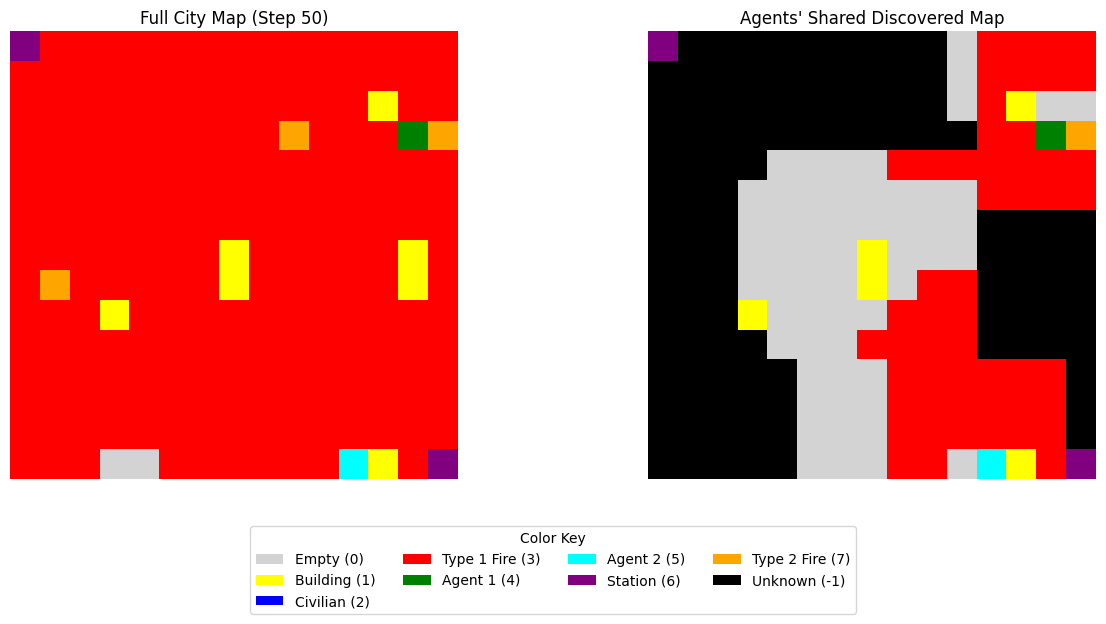

Game Over! Final Score: -670
Type 1 Fires extinguished: 13/5
Type 2 Fires extinguished: 0/3
Civilians rescued: 0/8

LLM Responses for All Steps:

Step 0 - Agent 1:
Prompt:

[AGENT STATUS]
Agent ID: 1
Grid size: (15, 15)
Agent Position: (0, 12)
Other Agent Position: [7, 5]
Shared Map (15x15, -1=unknown, 0=empty, 1=building, 2=civilian, 3=Type1 fire, 4=agent1, 5=agent2, 6=station, 7=type2 fire):
[[ 6, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  4,  3,  0],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,  0],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  1,  0,  0],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1,  0,  0,  0,  0,  3, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1,  0,  0,  5,  0,  1, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1,  0,  0,  0,  0,  1, -1, -1, -1, -1, -1, -1, -1],
 [-1, -1, -1,  1,  0,  0,  0,  0, -1

In [6]:
await run_multi_agent_simulation()